In [12]:
import pandas as pd
import numpy as np
import json
from typing import Dict, List
import re
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import single_meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from difflib import SequenceMatcher
import spacy
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict, List
import evaluate



In [13]:
# %pip install spacy rouge-score nltk
# !python -m spacy download en_core_web_md
# %pip install evaluate

In [14]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_md')
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge = evaluate.load("rouge")
sns.set_theme(style="whitegrid")


[nltk_data] Downloading package punkt to /home/asuran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/asuran/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/asuran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def create_evaluation_dataframe(records):
    """Create comprehensive dataframe with all relevant fields"""
    evaluation_data = []
    
    for record in records:
        try:
            patient_info = {
                # Patient Demographics
                'patient_id': record['patientId'],
                'gender': record['patientRecord']['Gender'],
                'age': int(record['patientRecord']['Age']),
                'weight': float(record['patientRecord']['Weight']),
                'height': float(record['patientRecord']['Height']),
                'blood_type': record['patientRecord']['Blood type'],
                'severity': record['patientRecord']['Severity'],
                'symptom_duration': record['patientRecord']['Duration of the symptoms'],
                'num_previous_visits': record['patientRecord']['Number of previous visits'],
                'symptoms': record['patientRecord']['Detailed symptoms'],
                'existing_conditions': record['patientRecord']['Existing medical conditions'],
                'allergies': record['patientRecord']['Allergies'],
                'medications': record['patientRecord']['Current medications'],
                
                # Ground Truth (Palm2 Model)
                'gt_primary_diagnosis': record['diagnosisReport']['Possible Diagnoses']['Primary Diagnosis'],
                'gt_differential_diagnoses': ','.join(record['diagnosisReport']['Possible Diagnoses']['Differential Diagnoses']),
                'gt_reasoning': record['diagnosisReport']['Reasoning Process'],
                'gt_tests': record['diagnosisReport']['Recommended Tests or Examinations'],
                'gt_treatments': record['diagnosisReport']['Potential Treatment Options'],
                'gt_precautions': record['diagnosisReport']['Immediate Precautions or Recommendations'],
                'gt_followup': record['diagnosisReport']['Follow-up Plan'],
                
                # Model Predictions (Med42)
                'pred_primary_diagnosis': record['med42_diagnosis']['Possible Diagnoses']['Primary Diagnosis'],
                'pred_differential_diagnoses': ','.join(record['med42_diagnosis']['Possible Diagnoses']['Differential Diagnoses']),
                'pred_reasoning': record['med42_diagnosis']['Reasoning Process'],
                'pred_tests': record['med42_diagnosis']['Recommended Tests or Examinations'],
                'pred_treatments': record['med42_diagnosis']['Potential Treatment Options'],
                'pred_precautions': record['med42_diagnosis']['Immediate Precautions or Recommendations'],
                'pred_followup': record['med42_diagnosis']['Follow-up Plan']
            }
            
            evaluation_data.append(patient_info)
            
        except Exception as e:
            print(f"Error processing record {record['patientId']}: {str(e)}")
            continue
    
    return pd.DataFrame(evaluation_data)

In [16]:
# Load the JSON data
with open('records_with_med42.json', 'r') as f:
    records = json.load(f)

In [17]:
# Create the dataframe
df = create_evaluation_dataframe(records)

In [18]:
print("DataFrame shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
display(df.head())

DataFrame shape: (956, 27)

Columns: ['patient_id', 'gender', 'age', 'weight', 'height', 'blood_type', 'severity', 'symptom_duration', 'num_previous_visits', 'symptoms', 'existing_conditions', 'allergies', 'medications', 'gt_primary_diagnosis', 'gt_differential_diagnoses', 'gt_reasoning', 'gt_tests', 'gt_treatments', 'gt_precautions', 'gt_followup', 'pred_primary_diagnosis', 'pred_differential_diagnoses', 'pred_reasoning', 'pred_tests', 'pred_treatments', 'pred_precautions', 'pred_followup']

Sample of the data:


,patient_id,gender,age,weight,height,blood_type,severity,symptom_duration,num_previous_visits,symptoms,...,gt_treatments,gt_precautions,gt_followup,pred_primary_diagnosis,pred_differential_diagnoses,pred_reasoning,pred_tests,pred_treatments,pred_precautions,pred_followup
0,2,Male,12,45.0,155.0,O-,Moderate,2 weeks,0,"Persistent, localized pain in the left knee, e...",...,- Rest and activity modification: Avoiding act...,- Avoid strenuous activities that aggravate th...,- Follow-up in 2-3 weeks to assess the effecti...,Osteochondritis Dissecans (OCD),"Juvenile Rheumatoid Arthritis (JRA),Traumatic ...",Osteochondritis Dissecans (OCD) is the most li...,- X-ray of the left knee to asses for any bone...,- Activity modification to reduce stress on th...,- Avoid high-impact physical activities to pre...,- Schedule a follow-up appointment in 4 to 6 w...
1,1,Female,28,60.0,165.0,AB-,Moderate,3 days,0,1. Intermittent sharp pain in the right lower ...,...,"- If appendicitis is confirmed, surgical appen...",- The patient should avoid eating or drinking ...,"- If appendectomy is performed, follow-up will...",Appendicitis,"Crohn's disease,Ovarian cyst rupture,Diverticu...",The primary diagnosis of appendicitis is based...,- Abdominal ultrasound to rule out ovarian cys...,- Antibiotics if appendicitis is confirmed eit...,- Monitor vital signs closely for any signs of...,- Arrange for the patient to be admitted for i...
2,3,Female,52,70.0,165.0,O-,Moderate,3 days,2,Intermittent sharp pain in the right flank rad...,...,- Hydration: Encourage increased fluid intake ...,"- Increase fluid intake significantly (water,...",- Follow-up appointment in 7-10 days for revie...,Pyelonephritis - Differential Diagnoses: - Kid...,,"- Applying Occam's razor, pyelonephritis seems...",- Urinalysis - Cystoscopy - Renal Ultrasound -...,- Antimicrobial therapy guided by urine cultur...,- Monitor the patient's symptom resolution and...,- Follow-up in 3 days for reassessment and uri...
3,4,Male,28,78.0,175.0,AB-,Moderate,3 weeks,0,"Persistent, dull ache in the right flank radia...",...,- If kidney stone is confirmed: Treatment wil...,- Increase fluid intake significantly (at leas...,- Follow-up appointment in 1 week for review o...,Kidney Stone (Nephrolithiasis),"Pyelonephritis (Infection of the kidney),Testi...","- The patient complains of a persistent, dull ...","- Urinalysis to check for blood, leukocyte est...",- Pain management: morphine or other strong op...,- Advise patient to avoid heavy lifting and be...,- Schedule a follow-up appointment within one ...
4,5,Female,52,70.0,165.0,A-,Moderate,6 months,2,"1. Persistent, dull ache in the right upper qu...",...,"- If gallstones are confirmed, the primary tre...",- Advise the patient to avoid fatty foods and ...,- Follow-up appointment in one week to review ...,Cholecystitis (inflammation of the gallbladder),"Gallbladder cancer, although less likely given...","The symptoms, particularly the right upper qua...",- Abdominal ultrasonography: Confirmed thicken...,- Antibiotic therapy to manage acute inflammat...,- Avoidance of foods high in fat and cholester...,- Schedule appointment with a gastroenterologi...


In [19]:
def add_derived_features(df):
    """Add derived features and metrics to the dataframe"""
    
    # Store original columns
    original_columns = df.columns.tolist()
    
    # Calculate BMI
    df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
    
    # Convert symptom duration to days
    def duration_to_days(duration):
        try:
            duration = str(duration).lower()
            if 'week' in duration:
                return int(duration.split()[0]) * 7
            elif 'month' in duration:
                return int(duration.split()[0]) * 30
            elif 'day' in duration:
                return int(duration.split()[0])
            return 0
        except:
            return 0
    
    df['symptom_duration_days'] = df['symptom_duration'].apply(duration_to_days)
    

    df['num_conditions'] = df['existing_conditions'].str.count(',') + 1
    

    df['num_medications'] = df['medications'].str.count(',') + 1
    

    new_columns = [col for col in df.columns if col not in original_columns]
    print("Added derived features. New columns:", new_columns)
    
    return df



In [20]:
# Add derived features
df = add_derived_features(df)

Added derived features. New columns: ['bmi', 'symptom_duration_days', 'num_conditions', 'num_medications']


In [21]:
df.head(2)

,patient_id,gender,age,weight,height,blood_type,severity,symptom_duration,num_previous_visits,symptoms,...,pred_differential_diagnoses,pred_reasoning,pred_tests,pred_treatments,pred_precautions,pred_followup,bmi,symptom_duration_days,num_conditions,num_medications
0,2,Male,12,45.0,155.0,O-,Moderate,2 weeks,0,"Persistent, localized pain in the left knee, e...",...,"Juvenile Rheumatoid Arthritis (JRA),Traumatic ...",Osteochondritis Dissecans (OCD) is the most li...,- X-ray of the left knee to asses for any bone...,- Activity modification to reduce stress on th...,- Avoid high-impact physical activities to pre...,- Schedule a follow-up appointment in 4 to 6 w...,18.730489,14,1,1
1,1,Female,28,60.0,165.0,AB-,Moderate,3 days,0,1. Intermittent sharp pain in the right lower ...,...,"Crohn's disease,Ovarian cyst rupture,Diverticu...",The primary diagnosis of appendicitis is based...,- Abdominal ultrasound to rule out ovarian cys...,- Antibiotics if appendicitis is confirmed eit...,- Monitor vital signs closely for any signs of...,- Arrange for the patient to be admitted for i...,22.038567,3,1,1


In [22]:
df

,patient_id,gender,age,weight,height,blood_type,severity,symptom_duration,num_previous_visits,symptoms,...,pred_differential_diagnoses,pred_reasoning,pred_tests,pred_treatments,pred_precautions,pred_followup,bmi,symptom_duration_days,num_conditions,num_medications
0,2,Male,12,45.0,155.0,O-,Moderate,2 weeks,0,"Persistent, localized pain in the left knee, e...",...,"Juvenile Rheumatoid Arthritis (JRA),Traumatic ...",Osteochondritis Dissecans (OCD) is the most li...,- X-ray of the left knee to asses for any bone...,- Activity modification to reduce stress on th...,- Avoid high-impact physical activities to pre...,- Schedule a follow-up appointment in 4 to 6 w...,18.730489,14,1,1
1,1,Female,28,60.0,165.0,AB-,Moderate,3 days,0,1. Intermittent sharp pain in the right lower ...,...,"Crohn's disease,Ovarian cyst rupture,Diverticu...",The primary diagnosis of appendicitis is based...,- Abdominal ultrasound to rule out ovarian cys...,- Antibiotics if appendicitis is confirmed eit...,- Monitor vital signs closely for any signs of...,- Arrange for the patient to be admitted for i...,22.038567,3,1,1
2,3,Female,52,70.0,165.0,O-,Moderate,3 days,2,Intermittent sharp pain in the right flank rad...,...,,"- Applying Occam's razor, pyelonephritis seems...",- Urinalysis - Cystoscopy - Renal Ultrasound -...,- Antimicrobial therapy guided by urine cultur...,- Monitor the patient's symptom resolution and...,- Follow-up in 3 days for reassessment and uri...,25.711662,3,2,2
3,4,Male,28,78.0,175.0,AB-,Moderate,3 weeks,0,"Persistent, dull ache in the right flank radia...",...,"Pyelonephritis (Infection of the kidney),Testi...","- The patient complains of a persistent, dull ...","- Urinalysis to check for blood, leukocyte est...",- Pain management: morphine or other strong op...,- Advise patient to avoid heavy lifting and be...,- Schedule a follow-up appointment within one ...,25.469388,21,1,1
4,5,Female,52,70.0,165.0,A-,Moderate,6 months,2,"1. Persistent, dull ache in the right upper qu...",...,"Gallbladder cancer, although less likely given...","The symptoms, particularly the right upper qua...",- Abdominal ultrasonography: Confirmed thicken...,- Antibiotic therapy to manage acute inflammat...,- Avoidance of foods high in fat and cholester...,- Schedule appointment with a gastroenterologi...,25.711662,180,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,996,Male,52,85.0,178.0,AB-,Moderate,2 months,2,Persistent epigastric pain radiating to the ba...,...,"Gastritis,Cholecystitis,Pancreatitis",The primary diagnosis is Peptic Ulcer Disease ...,- Complete Blood Count (CBC) with differential...,- Antacids to offer symptomatic relief for pai...,"- Advise the patient to consume smaller, more ...",- Schedule a follow-up appointment within 2 we...,26.827421,60,2,1
952,997,Male,12,45.0,155.0,O-,Moderate,3 days,2,"Persistent, localized abdominal pain in the lo...",...,"Intussusception,Ovarian torsion (considered fo...",,- Abdominal ultrasound to confirm or rule out ...,- Surgical consultation for possible appendect...,- Avoid NSAIDs for pain relief due to known ga...,- Emergent surgical intervention if deteriorat...,18.730489,3,1,1
953,998,Female,28,60.0,165.0,A-,Moderate,3 days,2,Intermittent sharp pain in the right lower qua...,...,"Gastroenteritis,Ovarian cyst or torsion",Acute appendicitis is the most likely diagnosi...,- Complete blood count (CBC) to check for leuk...,- Undergo immediate surgical consult for poten...,- Advise the patient to rest and avoid strenuo...,- Schedule immediate follow-up the next busine...,22.038567,3,2,1
954,999,Female,52,70.0,165.0,A+,Moderate,3 months,2,"Persistent fatigue for the past 3 months, inte...",...,"Irritable Bowel Syndrome (IBS),Osteoarthritis ...",The primary diagnosis of chronic diverticuliti...,- Abdominal CT scan with contrast to confirm t...,- Antibiotics targeting common bacterial patho...,- Advise patient to avoid straining during bow...,- Schedule a follow-up appoint

In [23]:
def calculate_bleu(references, candidates, weights):
    """Calculate BLEU score"""
    tokenized_candidates = [text.split() for text in candidates]
    tokenized_references = [[text.split()] for text in references]
    bleu_scores = corpus_bleu(tokenized_references, tokenized_candidates, weights=weights)
    return bleu_scores

def calculate_rouge(references, candidates):
    """Calculate ROUGE scores"""
    return rouge.compute(predictions=candidates, references=references)

def calculate_meteor(references, candidates):
    """Calculate METEOR score"""
    scores = [single_meteor_score(ref.split(), hyp.split()) 
             for ref, hyp in zip(references, candidates)]
    return sum(scores)/len(scores)

def jaccard_similarity(reference, generated):
    """Calculate Jaccard similarity"""
    generated_tokens = set(generated.split())
    reference_tokens = set(reference.split())
    intersection = len(generated_tokens & reference_tokens)
    union = len(generated_tokens | reference_tokens)
    return intersection / union if union > 0 else 0

def calculate_jaccard_similarity(references, candidates):
    """Calculate average Jaccard similarity"""
    scores = [jaccard_similarity(references[i], candidates[i]) 
             for i in range(len(references))]
    return sum(scores)/len(scores)

def evaluate_metrics(references, candidates, bleu_weights=(0.2, 0.3, 0.5)):
    """Calculate all evaluation metrics"""
    results = {
        'bleu': calculate_bleu(references, candidates, bleu_weights),
        'meteor_score': calculate_meteor(references, candidates),
        'jaccard_similarity': calculate_jaccard_similarity(references, candidates)
    }
    results.update(calculate_rouge(references, candidates))
    return results

def calculate_similarity_metrics(row):
    """Calculate comprehensive similarity metrics for a row"""
    metrics = {}
    
    # Primary Diagnosis Similarity
    primary_gt = str(row['gt_primary_diagnosis'])
    primary_pred = str(row['pred_primary_diagnosis'])
    
    # BLEU score
    metrics['primary_bleu'] = sentence_bleu(
        [word_tokenize(primary_gt.lower())],
        word_tokenize(primary_pred.lower())
    )
    
    # ROUGE scores
    rouge_scores = rouge_scorer.score(primary_gt, primary_pred)
    metrics['primary_rouge1'] = rouge_scores['rouge1'].fmeasure
    metrics['primary_rouge2'] = rouge_scores['rouge2'].fmeasure
    metrics['primary_rougeL'] = rouge_scores['rougeL'].fmeasure
    
    # Semantic similarity
    metrics['primary_semantic'] = nlp(primary_gt).similarity(nlp(primary_pred))
    
    # Sequence similarity
    metrics['primary_sequence'] = SequenceMatcher(None, primary_gt, primary_pred).ratio()
    
    # Differential Diagnoses Similarity
    diff_gt = row['gt_differential_diagnoses']
    diff_pred = row['pred_differential_diagnoses']
    diff_scores = rouge_scorer.score(diff_gt, diff_pred)
    metrics['diff_rouge1'] = diff_scores['rouge1'].fmeasure
    metrics['diff_rouge2'] = diff_scores['rouge2'].fmeasure
    metrics['diff_rougeL'] = diff_scores['rougeL'].fmeasure
    
    return pd.Series(metrics)

def calculate_evaluation_metrics(df):
    """Calculate all evaluation metrics before bias analysis"""
    print("Calculating evaluation metrics...")
    
    # Prepare references and candidates
    references = df['gt_primary_diagnosis'].tolist()
    candidates = df['pred_primary_diagnosis'].tolist()
    
    # Calculate all metrics
    results = evaluate_metrics(references, candidates, bleu_weights=(0.2, 0.3, 0.5))
    print("\nOverall Metrics:")
    print(json.dumps(results, indent=2))
    
    # Calculate detailed metrics for each row
    detailed_metrics = df.apply(calculate_similarity_metrics, axis=1)
    df_with_metrics = pd.concat([df, detailed_metrics], axis=1)
    
    print("\nSimilarity metrics summary:")
    metric_cols = [col for col in df_with_metrics.columns 
                  if any(x in col for x in ['bleu', 'rouge', 'semantic', 'sequence'])]
    display(df_with_metrics[metric_cols].describe())
    
    # Visualize metrics distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_with_metrics[[
        'primary_semantic', 'primary_sequence', 'primary_rouge1',
        'diff_rouge1', 'diff_rouge2', 'diff_rougeL'
    ]])
    plt.xticks(rotation=45)
    plt.title('Distribution of Similarity Metrics')
    plt.show()
    
    # Add agreement levels
    def classify_agreement(row):
        if row['primary_semantic'] > 0.8:
            return 'High'
        elif row['primary_semantic'] > 0.5:
            return 'Moderate'
        else:
            return 'Low'
    
    df_with_metrics['agreement_level'] = df_with_metrics.apply(classify_agreement, axis=1)
    agreement_dist = df_with_metrics['agreement_level'].value_counts()
    
    print("\nAgreement Level Distribution:")
    for level, count in agreement_dist.items():
        print(f"{level} Agreement: {count} cases ({count/len(df_with_metrics)*100:.1f}%)")
    
    return df_with_metrics

Calculating evaluation metrics...

Overall Metrics:
{
  "bleu": 0.03136926730292788,
  "meteor_score": 0.15052614329123062,
  "jaccard_similarity": 0.14103345073202986,
  "rouge1": 0.2663368055622236,
  "rouge2": 0.08448426538781978,
  "rougeL": 0.25899364829109317,
  "rougeLsum": 0.2594435306461593
}


/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/asuran/Downloads/projects/MedScript/MedEnv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram o


Similarity metrics summary:


,primary_bleu,primary_rouge1,primary_rouge2,primary_rougeL,primary_semantic,primary_sequence,diff_rouge1,diff_rouge2,diff_rougeL
count,9.560000e+02,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000
mean,2.885583e-02,0.279133,0.100976,0.272063,0.535284,0.393938,0.214341,0.090928,0.187626
std,1.437262e-01,0.333920,0.231780,0.328333,0.349557,0.278142,0.198782,0.147024,0.175264
min,0.000000e+00,0.000000,0.000000,0.000000,-0.068930,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.166006,0.201685,0.000000,0.000000,0.000000
50%,5.092529e-232,0.153846,0.000000,0.153846,0.646534,0.346803,0.171429,0.000000,0.149074
75%,1.821832e-231,0.500000,0.000000,0.500000,0.819641,0.540541,0.333333,0.153846,0.288360
max,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,0.875000


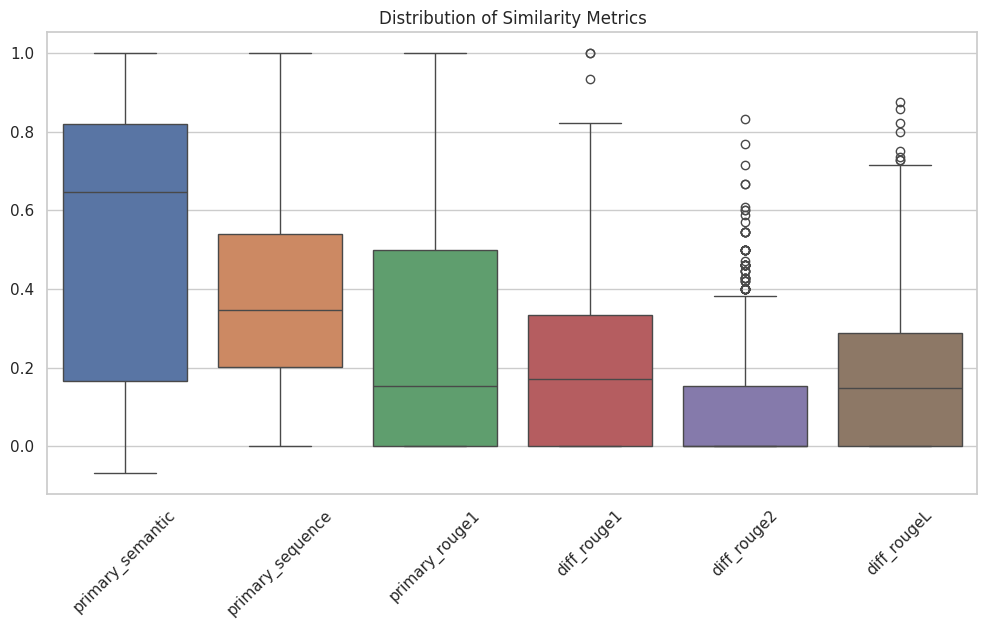


Agreement Level Distribution:
Low Agreement: 362 cases (37.9%)
Moderate Agreement: 328 cases (34.3%)
High Agreement: 266 cases (27.8%)


In [24]:
df_metrics = calculate_evaluation_metrics(df)

In [25]:
df_metrics.to_csv('records-med42-metrics.csv', index=False)

## Bias Analysis 

In [26]:
class MedicalBiasAnalyzer:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare data for bias analysis"""
        # Age groups
        self.df['age_group'] = pd.cut(
            self.df['age'], 
            bins=[0, 20, 40, 60, 80, 100],
            labels=['0-20', '21-40', '41-60', '61-80', '80+']
        )
        
        # Condition complexity
        self.df['condition_complexity'] = self.df['existing_conditions'].str.count(',').apply(
            lambda x: 'Simple' if x <= 2 else 'Moderate' if x <= 5 else 'Complex'
        )
        
        # BMI categories
        self.df['bmi_category'] = pd.cut(
            self.df['bmi'],
            bins=[0, 18.5, 24.9, 29.9, float('inf')],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese']
        )
        
        # Symptom severity standardization
        self.df['severity'] = self.df['severity'].str.lower()

    def analyze_demographic_bias(self) -> Dict:
        """Analyze bias across demographic factors"""
        demographic_metrics = {}
        
        # Gender Analysis
        gender_metrics = self.df.groupby('gender').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # Perform t-test for gender bias
        gender_groups = self.df['gender'].unique()
        if len(gender_groups) >= 2:
            t_stat, p_value = stats.ttest_ind(
                self.df[self.df['gender'] == gender_groups[0]]['primary_semantic'],
                self.df[self.df['gender'] == gender_groups[1]]['primary_semantic']
            )
            gender_metrics['t_test'] = {'t_stat': t_stat, 'p_value': p_value}
        
        demographic_metrics['gender_bias'] = gender_metrics
        
        # Age Analysis
        age_metrics = self.df.groupby('age_group').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # ANOVA test for age groups
        age_groups = self.df.groupby('age_group')['primary_semantic'].apply(list)
        f_stat, p_value = stats.f_oneway(*age_groups)
        age_metrics['anova'] = {'f_stat': f_stat, 'p_value': p_value}
        
        demographic_metrics['age_bias'] = age_metrics
        
        return demographic_metrics

    def analyze_medical_condition_bias(self) -> Dict:
        """Analyze bias across medical conditions and severity"""
        condition_metrics = {}
        
        # Severity Analysis
        severity_metrics = self.df.groupby('severity').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # Condition Complexity Analysis
        complexity_metrics = self.df.groupby('condition_complexity').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        # BMI Category Analysis
        bmi_metrics = self.df.groupby('bmi_category').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'primary_rouge1': ['mean', 'std'],
            'diff_rouge1': ['mean', 'std']
        }).round(3)
        
        return {
            'severity_bias': severity_metrics,
            'complexity_bias': complexity_metrics,
            'bmi_bias': bmi_metrics
        }
    
    def analyze_bmi_bias(self):
        """Analyze bias based on BMI categories"""
        print("\nBMI Analysis Results:")
        
        # 1. Basic BMI Distribution
        bmi_dist = self.df['bmi_category'].value_counts()
        print("\nBMI Category Distribution:")
        print(bmi_dist)
        
        # 2. Average Model Agreement by BMI Category
        bmi_agreement = self.df.groupby('bmi_category')['primary_semantic'].agg([
            'mean', 'std', 'count'
        ]).round(3)
        print("\nModel Agreement by BMI Category:")
        print(bmi_agreement)
        
        # 3. Calculate ROUGE scores by BMI Category
        rouge_by_bmi = self.df.groupby('bmi_category')['primary_rouge1'].mean().round(3)
        print("\nROUGE-1 Scores by BMI Category:")
        print(rouge_by_bmi)
        
        # 4. Gender and BMI Interaction
        gender_bmi = pd.pivot_table(
            self.df,
            values='primary_semantic',
            index='bmi_category',
            columns='gender',
            aggfunc='mean'
        ).round(3)
        print("\nModel Agreement by BMI and Gender:")
        print(gender_bmi)
        
        # 5. Statistical Test
        bmi_groups = [group['primary_semantic'].values for name, group in self.df.groupby('bmi_category')]
        f_stat, p_value = stats.f_oneway(*bmi_groups)
        print("\nANOVA Test Results:")
        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.3f}")
        
        return {
            'distribution': bmi_dist.to_dict(),
            'agreement': bmi_agreement.to_dict(),
            'rouge_scores': rouge_by_bmi.to_dict(),
            'gender_interaction': gender_bmi.to_dict(),
            'statistical_test': {'f_stat': float(f_stat), 'p_value': float(p_value)}
        }
    
    def visualize_bmi_agreement(self,df):
        """Create scatter plot with clear legend"""
        
        # Simplify severity categories
        def simplify_severity(severity):
            severity = str(severity).lower()
            if 'severe' in severity and 'moderate' in severity:
                return 'Moderate to Severe'
            elif 'severe' in severity:
                return 'Severe'
            elif 'moderate' in severity:
                return 'Moderate'
            elif 'mild' in severity:
                return 'Mild'
            else:
                return 'Other'
        
        # Create simplified severity column
        df['severity_simple'] = df['severity'].apply(simplify_severity)
        
        # Create the plot
        plt.figure(figsize=(15, 10))
        
        # Create scatter plot
        g = sns.scatterplot(
            data=df,
            x='bmi',
            y='primary_semantic',
            hue='severity_simple',
            alpha=0.6,
            s=100  # point size
        )
        
        # Customize the plot
        plt.title('Model Agreement vs BMI by Severity Level', fontsize=14, pad=20)
        plt.xlabel('BMI', fontsize=12)
        plt.ylabel('Semantic Agreement Score', fontsize=12)
        
        # Move legend outside the plot
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title='Severity Level',
            title_fontsize=12
        )
        
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Adjust layout to prevent legend cutoff
        plt.tight_layout()
        
        plt.show()
        
        print("\nSummary Statistics by Severity Level:")
        summary = df.groupby('severity_simple').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'bmi': ['mean', 'std']
        }).round(3)
        print(summary)

    
    def visualize_bmi_agreement_with_stats(self,df):
        """Create scatter plot with statistics panel"""
        
        # Create figure with gridspec
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
        
        # Scatter plot
        ax1 = fig.add_subplot(gs[0])
        
        # Simplify severity categories
        df['severity_simple'] = df['severity'].apply(lambda x: 'Severe' if 'severe' in str(x).lower() 
                                                else ('Moderate' if 'moderate' in str(x).lower() 
                                                else ('Mild' if 'mild' in str(x).lower() else 'Other')))
        
        sns.scatterplot(
            data=df,
            x='bmi',
            y='primary_semantic',
            hue='severity_simple',
            alpha=0.6,
            s=100,
            ax=ax1
        )
        
        ax1.set_title('Model Agreement vs BMI by Severity Level', fontsize=14, pad=20)
        ax1.set_xlabel('BMI', fontsize=12)
        ax1.set_ylabel('Semantic Agreement Score', fontsize=12)
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Statistics panel
        ax2 = fig.add_subplot(gs[1])
        ax2.axis('off')
        
        # Calculate statistics
        stats_data = df.groupby('severity_simple').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'bmi': ['mean', 'std']
        }).round(3)
        
        # Create statistics table
        table_data = []
        for severity in stats_data.index:
            row = [
                severity,
                f"{stats_data.loc[severity, ('primary_semantic', 'mean')]:.2f} ± {stats_data.loc[severity, ('primary_semantic', 'std')]:.2f}",
                f"{stats_data.loc[severity, ('bmi', 'mean')]:.1f} ± {stats_data.loc[severity, ('bmi', 'std')]:.1f}",
                f"{int(stats_data.loc[severity, ('primary_semantic', 'count')])}"
            ]
            table_data.append(row)
        
        table = ax2.table(
            cellText=table_data,
            colLabels=['Severity', 'Agreement Score\n(mean ± std)', 'BMI\n(mean ± std)', 'Count'],
            loc='center',
            cellLoc='center'
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        plt.tight_layout()
        plt.show()



    def visualize_bmi_analysis(self):
        """Create visualizations for BMI-based analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. BMI Distribution
        sns.countplot(data=self.df, x='bmi_category', ax=axes[0,0])
        axes[0,0].set_title('Distribution of BMI Categories')
        axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
        
        # 2. Model Agreement by BMI
        sns.boxplot(data=self.df, x='bmi_category', y='primary_semantic', ax=axes[0,1])
        axes[0,1].set_title('Model Agreement by BMI Category')
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
        
        # 3. ROUGE Scores by BMI
        sns.boxplot(data=self.df, x='bmi_category', y='primary_rouge1')
        axes[1,0].set_title('ROUGE-1 Scores by BMI Category')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
        
        # 4. Gender and BMI Interaction
        self.visualize_bmi_agreement(self.df)

    def detailed_bmi_analysis(self) -> Dict:
        """Perform detailed analysis of BMI-related patterns"""
        detailed_analysis = {}
        
        # Analysis of condition complexity by BMI
        detailed_analysis['condition_complexity'] = self.df.groupby('bmi_category')['num_conditions'].mean().to_dict()
        
        # Analysis of symptom patterns by BMI
        def get_common_symptoms(group):
            # This assumes symptoms are comma-separated
            all_symptoms = ' '.join(group['symptoms']).lower()
            word_freq = pd.Series(all_symptoms.split()).value_counts().head(5)
            return word_freq.to_dict()
        
        detailed_analysis['symptom_patterns'] = self.df.groupby('bmi_category').apply(get_common_symptoms).to_dict()
        
        # Treatment recommendations by BMI
        def get_common_treatments(group):
            all_treatments = ' '.join(group['pred_treatments']).lower()
            word_freq = pd.Series(all_treatments.split()).value_counts().head(5)
            return word_freq.to_dict()
            
        detailed_analysis['treatment_patterns'] = self.df.groupby('bmi_category').apply(get_common_treatments).to_dict()
        
        # Calculate disparity scores
        def calculate_disparity(metrics):
            return (metrics.max() - metrics.min()) / metrics.mean()
            
        bmi_disparity = calculate_disparity(self.df.groupby('bmi_category')['primary_semantic'].mean())
        detailed_analysis['bmi_disparity_score'] = bmi_disparity
        
        return detailed_analysis
    
    def visualize_comprehensive_analysis(self):
        """Create comprehensive set of visualizations"""
        
        # Create simplified severity column first
        def simplify_severity(severity):
            severity = str(severity).lower()
            if 'severe' in severity and 'moderate' in severity:
                return 'Moderate to Severe'
            elif 'severe' in severity:
                return 'Severe'
            elif 'moderate' in severity:
                return 'Moderate'
            elif 'mild' in severity:
                return 'Mild'
            else:
                return 'Other'
        
        self.df['severity_simple'] = self.df['severity'].apply(simplify_severity)
        
        # Calculate number of conditions
        self.df['num_conditions'] = self.df['existing_conditions'].str.count(',') + 1
        
        # Create a 3x2 subplot grid
        fig = plt.figure(figsize=(20, 25))
        gs = fig.add_gridspec(3, 2)
        
        # 1. BMI Distribution with Gender Split
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(
            data=self.df,
            x='bmi',
            hue='gender',
            multiple="stack",
            bins=30,
            ax=ax1
        )
        ax1.set_title('BMI Distribution by Gender')
        ax1.set_xlabel('BMI')
        ax1.set_ylabel('Count')

        # 2. Age vs BMI Correlation
        ax2 = fig.add_subplot(gs[0, 1])
        sns.scatterplot(
            data=self.df,
            x='age',
            y='bmi',
            hue='gender',
            size='primary_semantic',
            sizes=(50, 200),
            alpha=0.6,
            ax=ax2
        )
        ax2.set_title('Age vs BMI (size indicates model agreement)')
        
        # 3. Condition Complexity by BMI Category
        ax3 = fig.add_subplot(gs[1, 0])
        sns.boxplot(
            data=self.df,
            x='bmi_category',
            y='num_conditions',
            ax=ax3
        )
        ax3.set_title('Number of Conditions by BMI Category')
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Model Agreement Heatmap
        ax4 = fig.add_subplot(gs[1, 1])
        agreement_pivot = pd.pivot_table(
            self.df,
            values='primary_semantic',
            index='bmi_category',
            columns='severity_simple',
            aggfunc='mean'
        ).fillna(0)  # Fill NaN values with 0
        
        sns.heatmap(
            agreement_pivot,
            annot=True,
            cmap='YlOrRd',
            fmt='.2f',
            ax=ax4
        )
        ax4.set_title('Model Agreement Heatmap\n(BMI Category vs Severity)')
        
        # 5. Performance Metrics by BMI Category
        ax5 = fig.add_subplot(gs[2, 0])
        metrics_df = pd.DataFrame({
            'Semantic Score': self.df.groupby('bmi_category')['primary_semantic'].mean(),
            'ROUGE Score': self.df.groupby('bmi_category')['primary_rouge1'].mean(),
            'Differential Score': self.df.groupby('bmi_category')['diff_rouge1'].mean()
        })
        metrics_df.plot(kind='bar', ax=ax5)
        ax5.set_title('Model Performance Metrics by BMI Category')
        plt.setp(ax5.get_xticklabels(), rotation=45)
        ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 6. Severity Distribution by BMI Category
        ax6 = fig.add_subplot(gs[2, 1])
        severity_counts = pd.crosstab(self.df['bmi_category'], self.df['severity_simple'])
        severity_counts.plot(kind='bar', stacked=True, ax=ax6)
        ax6.set_title('Severity Distribution by BMI Category')
        plt.setp(ax6.get_xticklabels(), rotation=45)
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary Statistics:")
        summary_stats = self.df.groupby('bmi_category').agg({
            'primary_semantic': ['mean', 'std', 'count'],
            'num_conditions': 'mean',
            'age': 'mean'
        }).round(2)
        print(summary_stats)

    def visualize_statistical_significance(self):
        """Visualize statistical significance of relationships"""
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # 1. Q-Q Plot for BMI Distribution
        stats.probplot(self.df['bmi'], dist="norm", plot=axes[0,0])
        axes[0,0].set_title('Q-Q Plot of BMI Distribution')
        
        # 2. ANOVA Results Visualization
        bmi_groups = [group['primary_semantic'].values 
                    for name, group in self.df.groupby('bmi_category')]
        f_stat, p_value = stats.f_oneway(*bmi_groups)
        
        # Create bar plot of means with error bars
        means = [np.mean(group) for group in bmi_groups]
        sems = [stats.sem(group) for group in bmi_groups]
        
        axes[0,1].bar(range(len(means)), means, yerr=sems)
        axes[0,1].set_title(f'Mean Agreement Scores by BMI Category\n(ANOVA p-value: {p_value:.3f})')
        axes[0,1].set_xticks(range(len(means)))
        axes[0,1].set_xticklabels(self.df['bmi_category'].unique(), rotation=45)
        
        # 3. Correlation Matrix
        corr_matrix = self.df[['bmi', 'primary_semantic', 'primary_rouge1', 'diff_rouge1']].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlation Matrix')
        
        # 4. Regression Plot
        sns.regplot(
            data=self.df,
            x='bmi',
            y='primary_semantic',
            scatter_kws={'alpha':0.5},
            ax=axes[1,1]
        )
        axes[1,1].set_title('BMI vs Model Agreement with Regression Line')
        
        plt.tight_layout()
        plt.show()


In [27]:
analyzer = MedicalBiasAnalyzer(df_metrics)

In [28]:

demographic_bias = analyzer.analyze_demographic_bias()

# Display results
print("Gender Bias Analysis:")
print(demographic_bias['gender_bias'])
print("\nAge Bias Analysis:")
print(demographic_bias['age_bias'])

Gender Bias Analysis:
       primary_semantic              primary_rouge1        diff_rouge1         \
                   mean    std count           mean    std        mean    std   
gender                                                                          
Female            0.533  0.355   480          0.280  0.332       0.216  0.202   
Male              0.538  0.344   476          0.278  0.336       0.213  0.196   

       t_test  
               
gender         
Female    NaN  
Male      NaN  

Age Bias Analysis:
          primary_semantic              primary_rouge1        diff_rouge1  \
                      mean    std count           mean    std        mean   
age_group                                                                   
0-20                 0.468  0.373   144          0.299  0.389       0.147   
21-40                0.535  0.369   337          0.310  0.363       0.231   
41-60                0.533  0.322   333          0.227  0.263       0.223   
61-80     

/tmp/ipykernel_21390/3181101192.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_metrics = self.df.groupby('age_group').agg({
/tmp/ipykernel_21390/3181101192.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = self.df.groupby('age_group')['primary_semantic'].apply(list)
/tmp/ipykernel_21390/3181101192.py:61: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = stats.f_oneway(*age_groups)


In [29]:
medical_bias = analyzer.analyze_medical_condition_bias()

# Display results
print("Severity Bias Analysis:")
print(medical_bias['severity_bias'])
print("\nCondition Complexity Bias Analysis:")
print(medical_bias['complexity_bias'])

Severity Bias Analysis:
                                                   primary_semantic         \
                                                               mean    std   
severity                                                                     
back pain - moderate, urinary frequency - mild,...            0.451    NaN   
back pain - moderate, urinary frequency - mild,...            0.714    NaN   
fatigue (moderate), knee pain (moderate), dizzi...            0.000    NaN   
fatigue - moderate, knee pain - moderate, palpi...            0.598    NaN   
fatigue - moderate; wrist pain - moderate; dizz...            0.272    NaN   
hip pain - moderate; memory problems - moderate...            0.428    NaN   
hip pain - moderate; urinary difficulty - mild;...            0.709    NaN   
hip pain - moderate; urinary difficulty - moder...            0.701    NaN   
hip pain - moderate; urinary difficulty - moder...            0.359  0.507   
hip pain - moderate; urinary difficulty 

/tmp/ipykernel_21390/3181101192.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_metrics = self.df.groupby('bmi_category').agg({


/tmp/ipykernel_21390/3181101192.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_agreement = self.df.groupby('bmi_category')['primary_semantic'].agg([
/tmp/ipykernel_21390/3181101192.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rouge_by_bmi = self.df.groupby('bmi_category')['primary_rouge1'].mean().round(3)
/tmp/ipykernel_21390/3181101192.py:121: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  gender_bmi = pd.pivot_table(
/tmp/ipyke


BMI Analysis Results:

BMI Category Distribution:
bmi_category
Overweight     516
Normal         440
Underweight      0
Obese            0
Name: count, dtype: int64

Model Agreement by BMI Category:
               mean    std  count
bmi_category                     
Underweight     NaN    NaN      0
Normal        0.505  0.374    440
Overweight    0.561  0.326    516
Obese           NaN    NaN      0

ROUGE-1 Scores by BMI Category:
bmi_category
Underweight      NaN
Normal         0.301
Overweight     0.261
Obese            NaN
Name: primary_rouge1, dtype: float64

Model Agreement by BMI and Gender:
gender        Female   Male
bmi_category               
Normal         0.545  0.455
Overweight     0.520  0.596

ANOVA Test Results:
F-statistic: nan
p-value: nan

BMI Analysis Summary:
{
  "distribution": {
    "Overweight": 516,
    "Normal": 440,
    "Underweight": 0,
    "Obese": 0
  },
  "agreement": {
    "mean": {
      "Underweight": NaN,
      "Normal": 0.505,
      "Overweight": 0

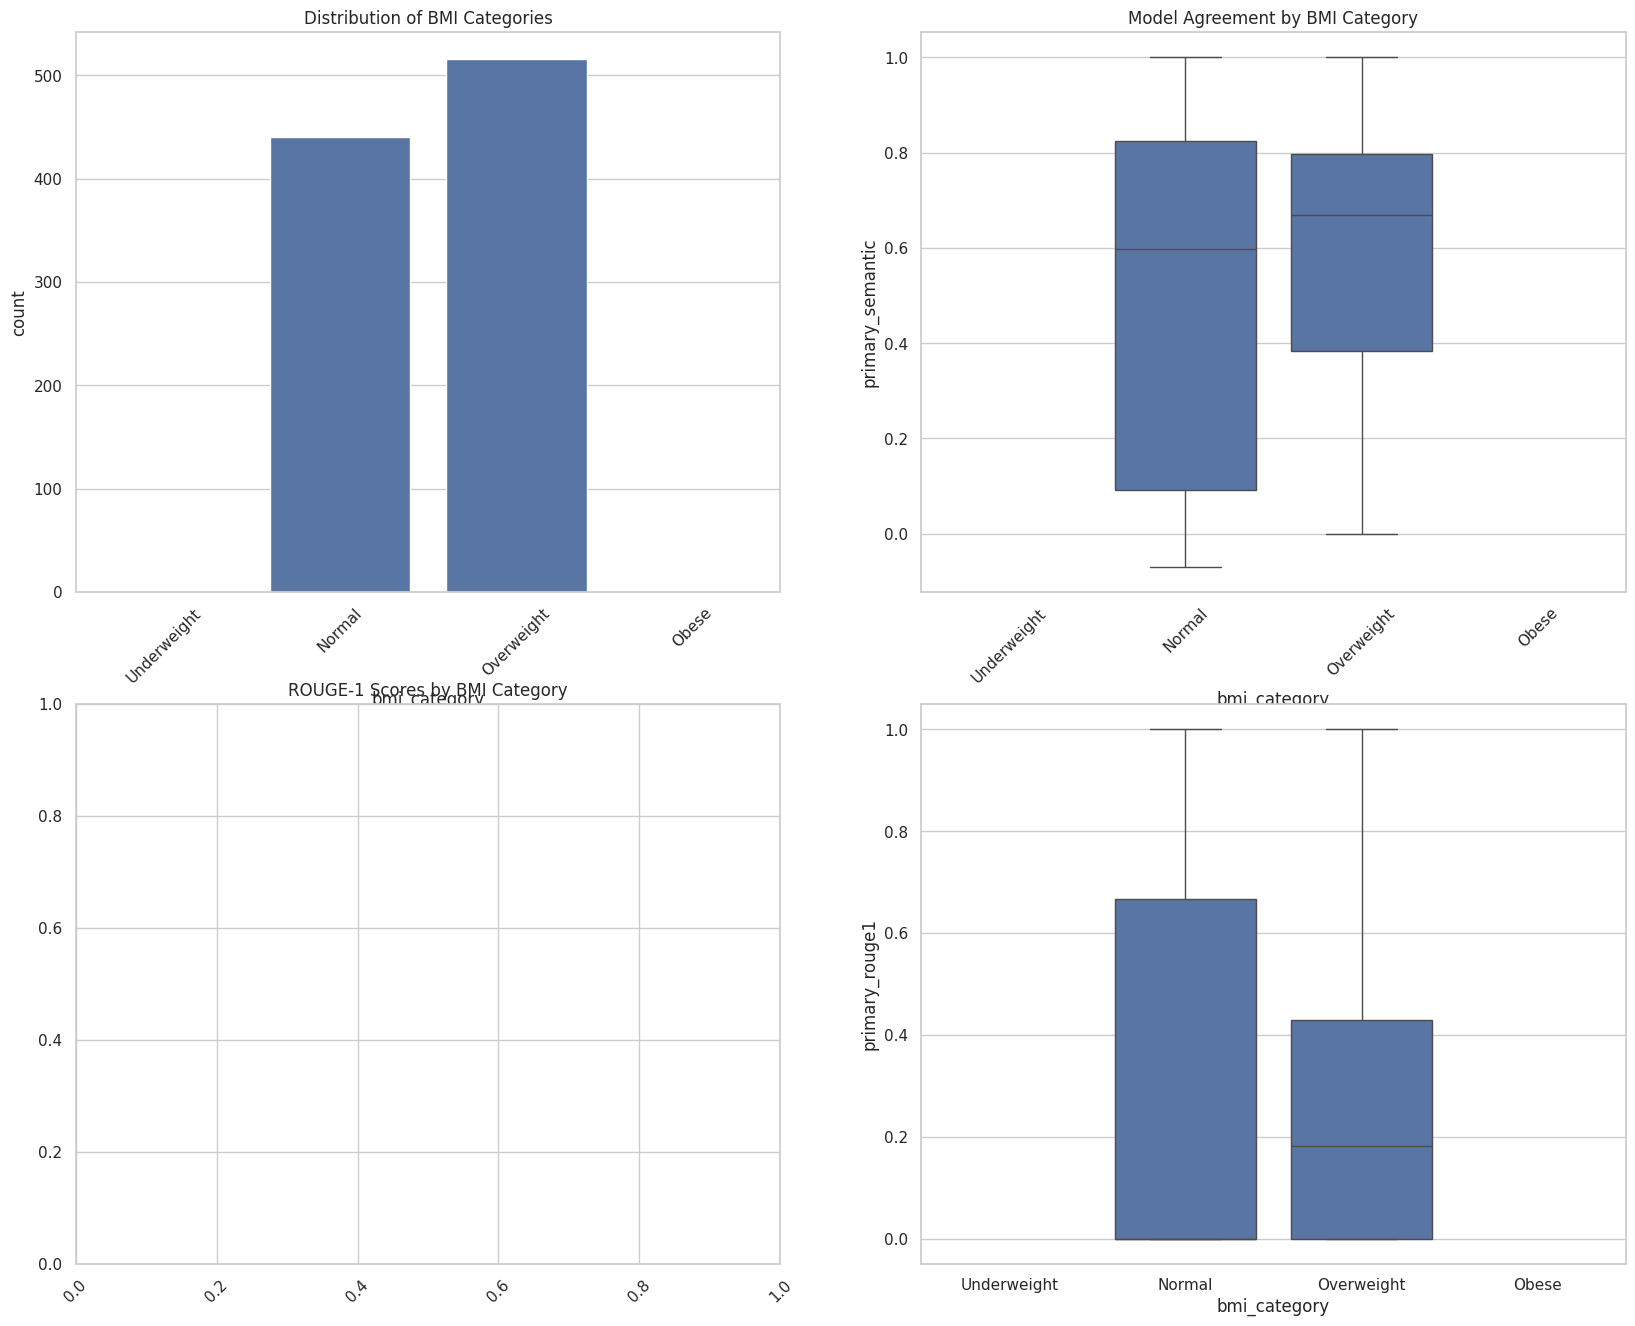

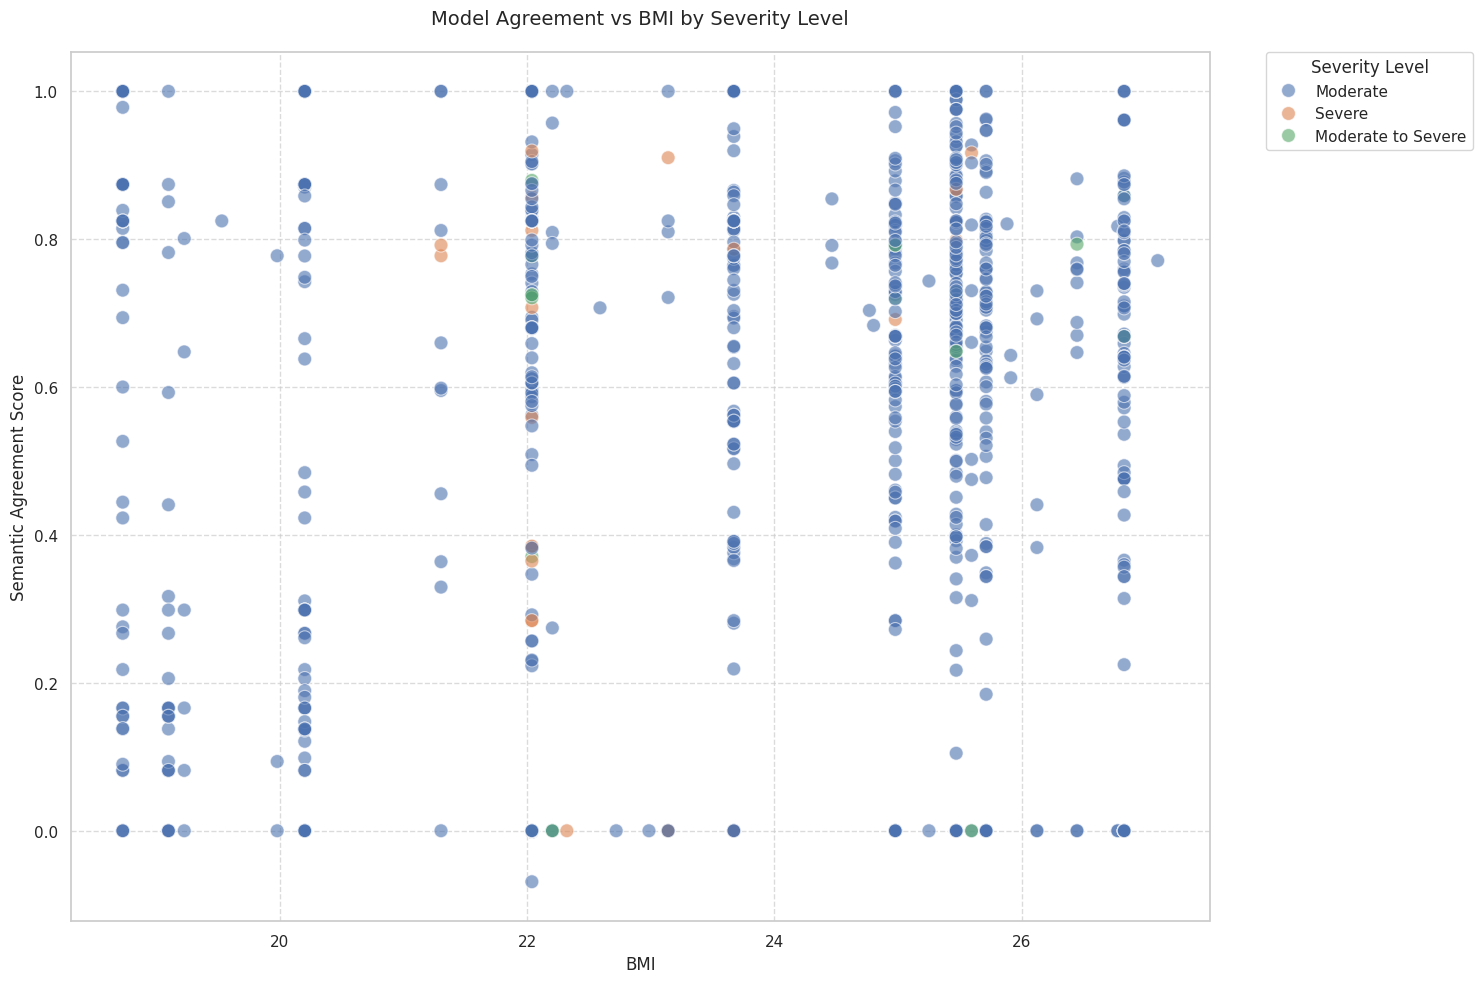


Summary Statistics by Severity Level:
                   primary_semantic                  bmi       
                               mean    std count    mean    std
severity_simple                                                
Moderate                      0.543  0.346   894  23.837  2.422
Moderate to Severe            0.478  0.370    23  24.069  1.891
Severe                        0.399  0.392    39  22.868  1.329

Detailed BMI Analysis:
{
  "condition_complexity": {
    "Underweight": NaN,
    "Normal": 1.4886363636363635,
    "Overweight": 2.044573643410853,
    "Obese": NaN
  },
  "symptom_patterns": {
    "Underweight": {},
    "Normal": {
      "the": 750,
      "right": 394,
      "in": 351,
      "pain": 324,
      "to": 303
    },
    "Overweight": {
      "the": 1099,
      "in": 508,
      "right": 479,
      "radiating": 436,
      "to": 385
    },
    "Obese": {}
  },
  "treatment_patterns": {
    "Underweight": {},
    "Normal": {
      "-": 1300,
      "and": 606,
  

/tmp/ipykernel_21390/3181101192.py:304: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_analysis['condition_complexity'] = self.df.groupby('bmi_category')['num_conditions'].mean().to_dict()
/tmp/ipykernel_21390/3181101192.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_analysis['symptom_patterns'] = self.df.groupby('bmi_category').apply(get_common_symptoms).to_dict()
/tmp/ipykernel_21390/3181101192.py:313: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from t

In [30]:
bmi_analysis = analyzer.analyze_bmi_bias()
print("\nBMI Analysis Summary:")
print(json.dumps(bmi_analysis, indent=2))

# Visualize BMI patterns
analyzer.visualize_bmi_analysis()

# Get detailed BMI analysis
detailed_bmi = analyzer.detailed_bmi_analysis()
print("\nDetailed BMI Analysis:")
print(json.dumps(detailed_bmi, indent=2))

/tmp/ipykernel_21390/3181101192.py:399: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  agreement_pivot = pd.pivot_table(
/tmp/ipykernel_21390/3181101192.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Semantic Score': self.df.groupby('bmi_category')['primary_semantic'].mean(),
/tmp/ipykernel_21390/3181101192.py:420: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'ROUGE Score': self.df.groupby('bmi_category')['primary_rouge1'].mean(),
/tmp/ipyk

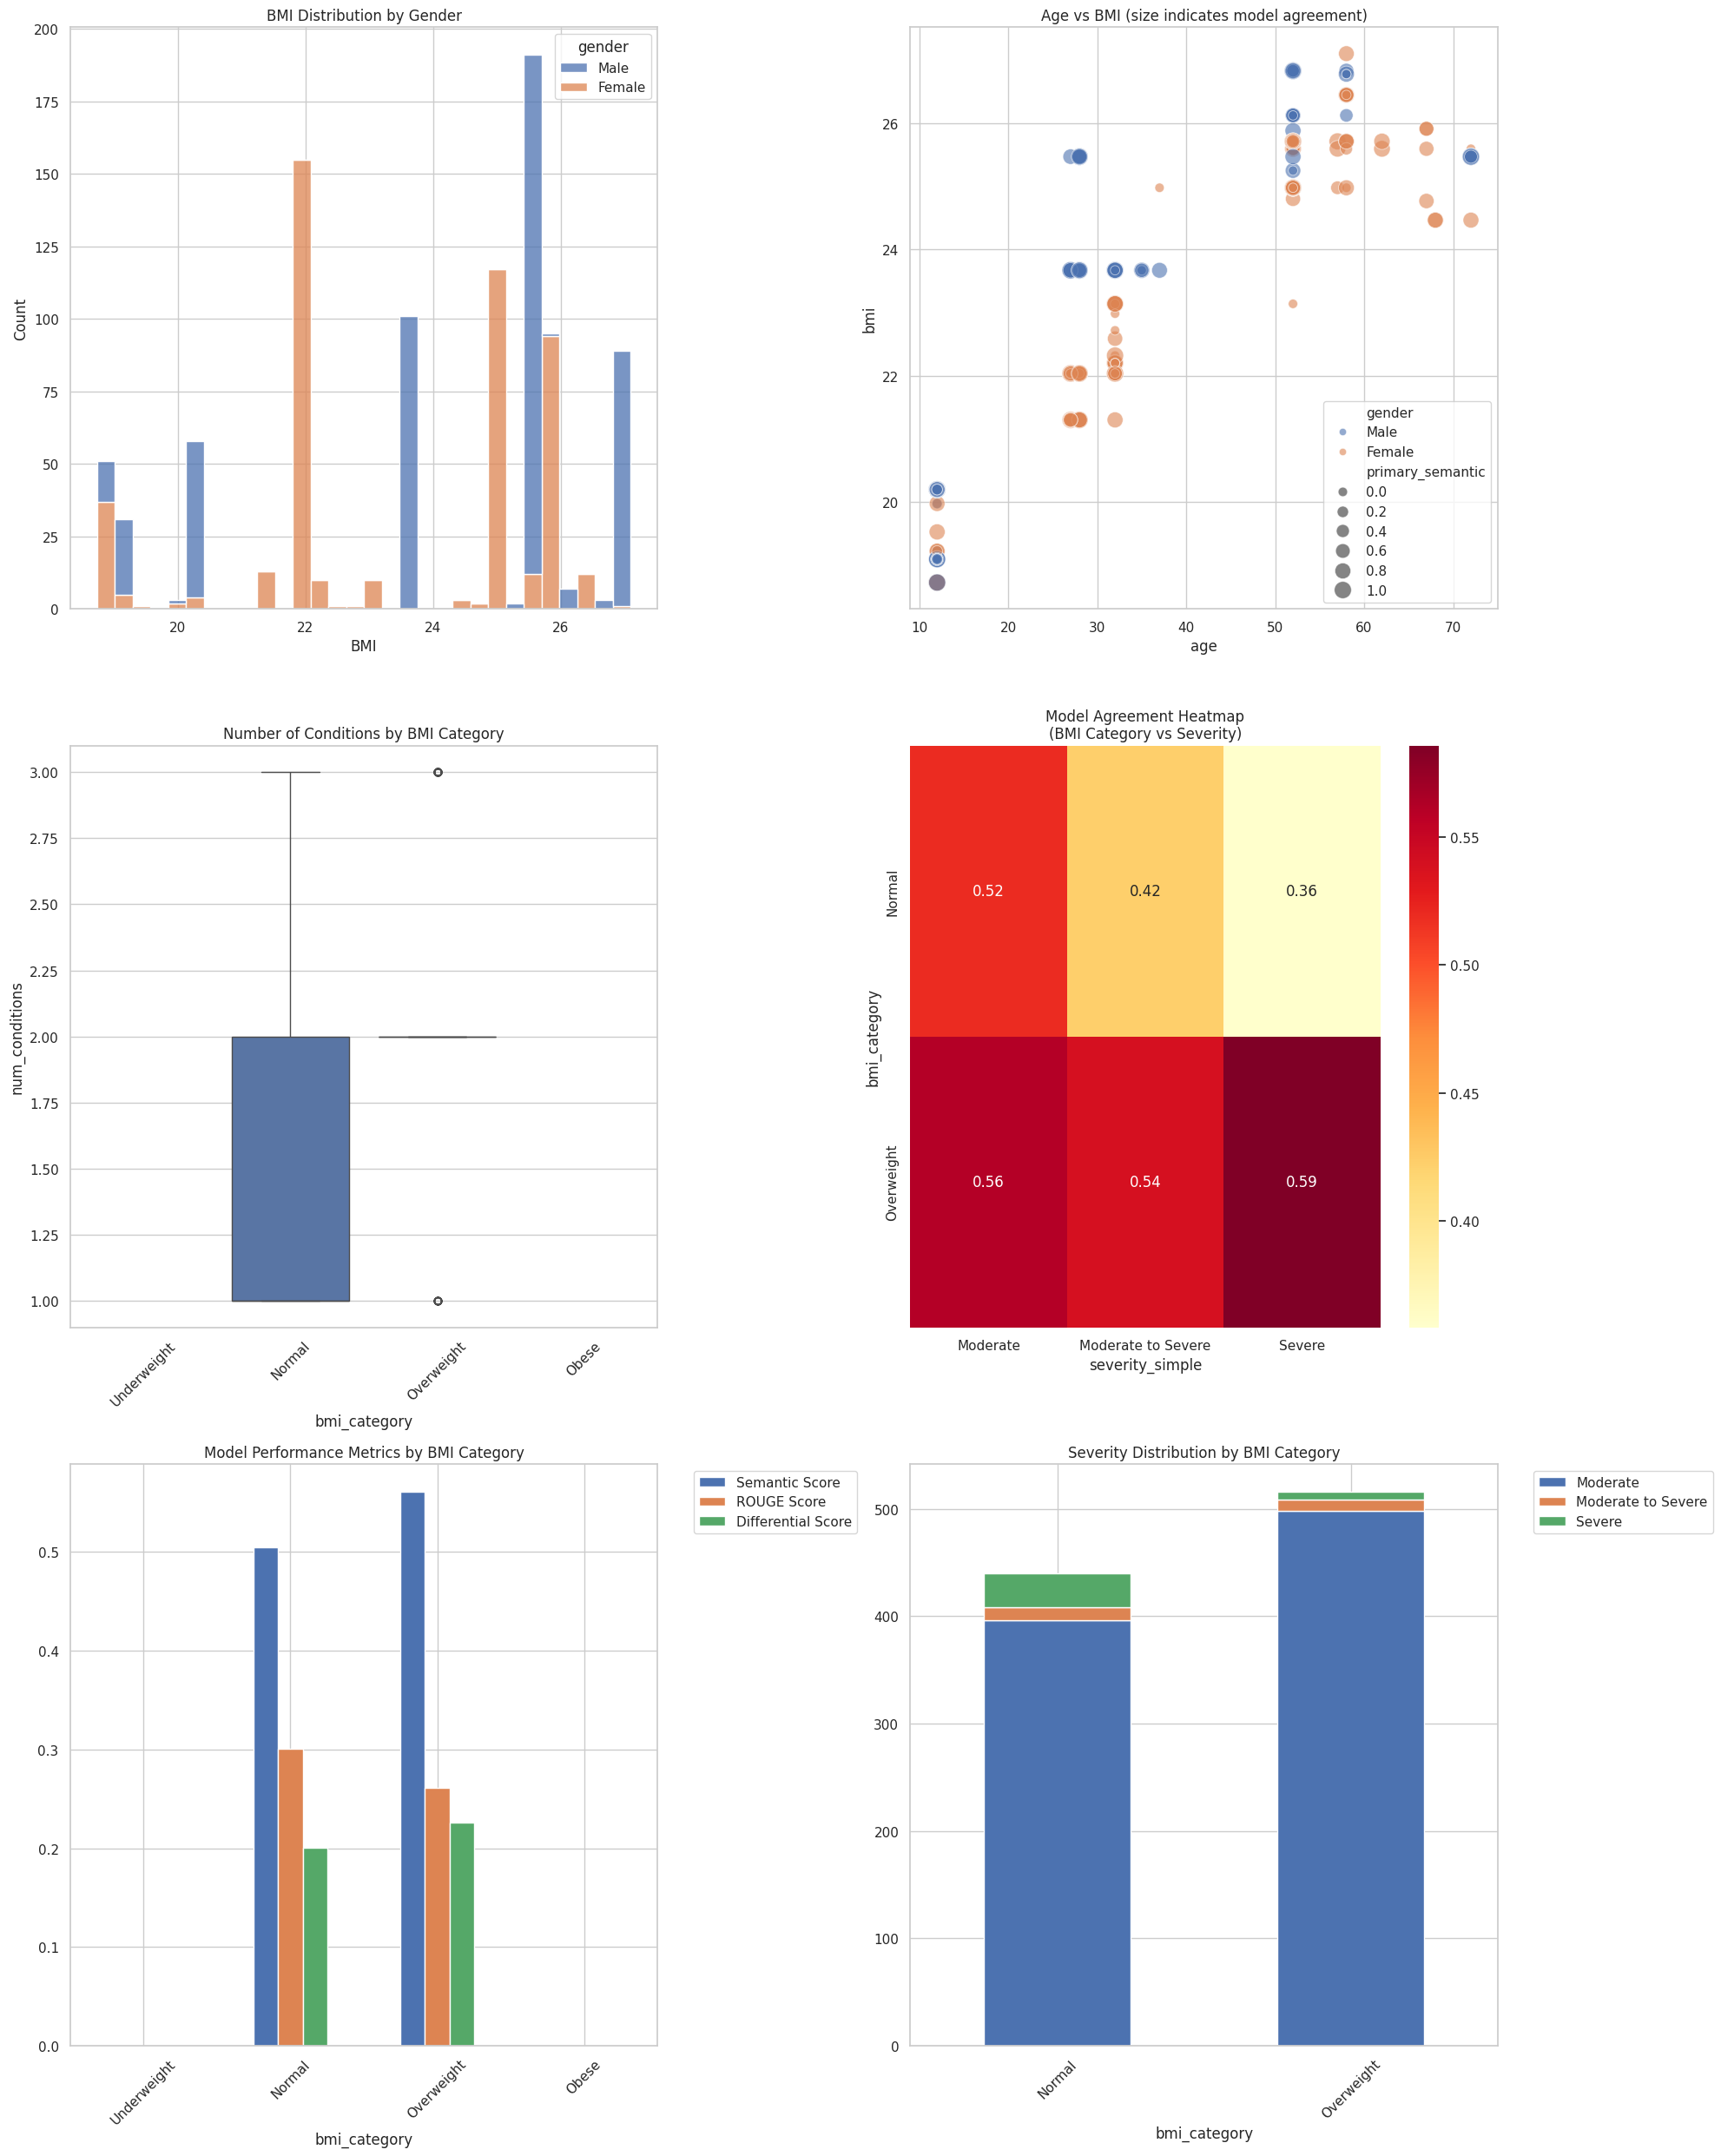


Summary Statistics:
             primary_semantic             num_conditions    age
                         mean   std count           mean   mean
bmi_category                                                   
Underweight               NaN   NaN     0            NaN    NaN
Normal                   0.51  0.37   440           1.49  23.99
Overweight               0.56  0.33   516           2.04  55.42
Obese                     NaN   NaN     0            NaN    NaN


/tmp/ipykernel_21390/3181101192.py:441: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = self.df.groupby('bmi_category').agg({


In [31]:
analyzer.visualize_comprehensive_analysis()

In [32]:
def analyze_sensitivity(df):
    """Comprehensive analysis of model sensitivity to various input factors"""
    
    # First create a copy to avoid modifying original dataframe
    df = df.copy()
    
    # 1. Create all necessary grouping columns
    print("Creating grouping columns...")
    
    # Symptom length grouping
    df['symptom_length'] = df['symptoms'].str.len()
    try:
        df['symptom_length_group'] = pd.qcut(df['symptom_length'], 
                                           q=4,
                                           labels=['Short', 'Medium', 'Long', 'Very Long'])
    except:
        print("Warning: Creating symptom length groups with duplicates dropped")
        df['symptom_length_group'] = pd.qcut(df['symptom_length'], 
                                           q=4,
                                           labels=['Short', 'Medium', 'Long', 'Very Long'],
                                           duplicates='drop')
    
    # Condition complexity grouping
    df['condition_complexity'] = pd.cut(df['num_conditions'],
                                      bins=[0, 2, 4, float('inf')],
                                      labels=['Simple', 'Moderate', 'Complex'])
    
    # Duration category grouping
    df['duration_category'] = pd.cut(df['symptom_duration_days'],
                                   bins=[0, 7, 30, 90, float('inf')],
                                   labels=['Acute', 'Sub-acute', 'Chronic', 'Long-term'])
    
    # Severity standardization
    df['severity'] = df['severity'].str.lower()
    df['severity_standardized'] = df['severity'].map(lambda x: 
        'Severe' if 'severe' in str(x) else
        'Moderate' if 'moderate' in str(x) else
        'Mild' if 'mild' in str(x) else 'Other'
    )

    # Age groups
    df['age_group'] = pd.cut(df['age'],
                            bins=[0, 18, 35, 50, 65, float('inf')],
                            labels=['0-18', '19-35', '36-50', '51-65', '65+'])
    
    # BMI categories
    df['bmi_category'] = pd.cut(df['bmi'],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, float('inf')],
                               labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'])
    
    # Gender standardization
    df['gender'] = df['gender'].str.lower()
    
    print("Grouping columns created successfully.")
    
    # 2. Define metrics to analyze
    metrics_list = [
        'primary_semantic', 'primary_sequence', 'primary_bleu',
        'primary_rouge1', 'primary_rouge2', 'primary_rougeL',
        'diff_rouge1', 'diff_rouge2', 'diff_rougeL'
    ]
    
    metric_names = {
        'primary_semantic': 'Semantic Similarity',
        'primary_sequence': 'Sequence Similarity',
        'primary_bleu': 'BLEU Score',
        'primary_rouge1': 'ROUGE-1',
        'primary_rouge2': 'ROUGE-2',
        'primary_rougeL': 'ROUGE-L',
        'diff_rouge1': 'Diff ROUGE-1',
        'diff_rouge2': 'Diff ROUGE-2',
        'diff_rougeL': 'Diff ROUGE-L'
    }
    
    def analyze_factor_sensitivity(group_col, factor_name):
        """Analyze sensitivity for a specific factor"""
        if group_col not in df.columns:
            print(f"Warning: {group_col} not found in dataframe")
            return None
            
        print(f"Analyzing {factor_name}...")
        try:
            stats = df.groupby(group_col, observed=True)[metrics_list].agg(['mean', 'std', 'count'])
            
            anova_results = {}
            for metric in metrics_list:
                groups = [group[metric].values for name, group in df.groupby(group_col, observed=True)]
                try:
                    f_stat, p_value = stats.f_oneway(*groups)
                except:
                    f_stat, p_value = np.nan, np.nan
                anova_results[metric] = {'f_statistic': f_stat, 'p_value': p_value}
            
            return {
                'statistics': stats,
                'anova_results': anova_results
            }
        except Exception as e:
            print(f"Error analyzing {factor_name}: {str(e)}")
            return None
    
    # 3. Run analysis for different factors
    factors = {
        'symptom_length': ('symptom_length_group', 'Symptom Length'),
        'medical_complexity': ('condition_complexity', 'Medical Complexity'),
        'duration': ('duration_category', 'Duration'),
        'severity': ('severity_standardized', 'Severity Level'),
        'age': ('age_group', 'Age Group'),
        'bmi': ('bmi_category', 'BMI Category'),
        'gender': ('gender', 'Gender')
    }
    
    sensitivity_analysis = {}
    for name, (col, label) in factors.items():
        result = analyze_factor_sensitivity(col, label)
        if result is not None:
            sensitivity_analysis[name] = result
    
    # 4. Create visualizations
    print("\nCreating visualizations...")
    successful_factors = [(name, (col, label)) 
                         for name, (col, label) in factors.items() 
                         if name in sensitivity_analysis]
    
    if successful_factors:
        # Create a figure with enough subplots for all factors
        num_factors = len(successful_factors)
        num_rows = (num_factors + 2) // 3  # 3 plots per row
        fig, axes = plt.subplots(num_rows, 3, figsize=(20, 7*num_rows))
        axes = axes.flatten() if num_rows > 1 else [axes]
        
        for idx, (name, (col, label)) in enumerate(successful_factors):
            if idx < len(axes):
                sns.boxplot(data=df, x=col, y='primary_semantic', ax=axes[idx])
                axes[idx].set_title(f'Performance vs {label}')
                axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
                axes[idx].set_ylabel('Semantic Similarity' if idx % 3 == 0 else '')
        
        # Hide unused subplots
        for idx in range(len(successful_factors), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Additional demographic-specific visualizations
        plt.figure(figsize=(15, 5))
        
        # Age and Performance relationship
        plt.subplot(131)
        sns.boxplot(data=df, x='age_group', y='primary_semantic')
        plt.title('Performance by Age Group')
        plt.xticks(rotation=45)
        
        # BMI and Performance
        plt.subplot(132)
        sns.boxplot(data=df, x='bmi_category', y='primary_semantic')
        plt.title('Performance by BMI Category')
        plt.xticks(rotation=45)
        
        # Gender and Performance
        plt.subplot(133)
        sns.boxplot(data=df, x='gender', y='primary_semantic')
        plt.title('Performance by Gender')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Interaction plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        # Age x Severity
        sns.boxplot(data=df, x='age_group', y='primary_semantic', 
                   hue='severity_standardized', ax=axes[0,0])
        axes[0,0].set_title('Age and Severity Interaction')
        axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
        
        # BMI x Severity
        sns.boxplot(data=df, x='bmi_category', y='primary_semantic',
                   hue='severity_standardized', ax=axes[0,1])
        axes[0,1].set_title('BMI and Severity Interaction')
        axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
        
        # Age x Complexity
        sns.boxplot(data=df, x='age_group', y='primary_semantic',
                   hue='condition_complexity', ax=axes[1,0])
        axes[1,0].set_title('Age and Complexity Interaction')
        axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
        
        # BMI x Complexity
        sns.boxplot(data=df, x='bmi_category', y='primary_semantic',
                   hue='condition_complexity', ax=axes[1,1])
        axes[1,1].set_title('BMI and Complexity Interaction')
        axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Extended correlation matrix including demographic factors
        demographic_features = ['age', 'bmi'] + metrics_list
        correlation_matrix = df[demographic_features].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                   center=0, fmt='.2f')
        plt.title('Correlation Matrix including Demographic Factors')
        plt.tight_layout()
        plt.show()

    return {
        'sensitivity_analysis': sensitivity_analysis,
        'correlation_matrix': correlation_matrix if 'correlation_matrix' in locals() else None,
        'processed_data': df,
        'demographic_summary': {
            'age': df.groupby('age_group')['primary_semantic'].describe(),
            'bmi': df.groupby('bmi_category')['primary_semantic'].describe(),
            'gender': df.groupby('gender')['primary_semantic'].describe()
        }
    }


Creating grouping columns...
Grouping columns created successfully.
Analyzing Symptom Length...
Analyzing Medical Complexity...
Analyzing Duration...
Analyzing Severity Level...
Analyzing Age Group...
Analyzing BMI Category...
Analyzing Gender...

Creating visualizations...


/tmp/ipykernel_21390/903251798.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:136: UserWarning: 

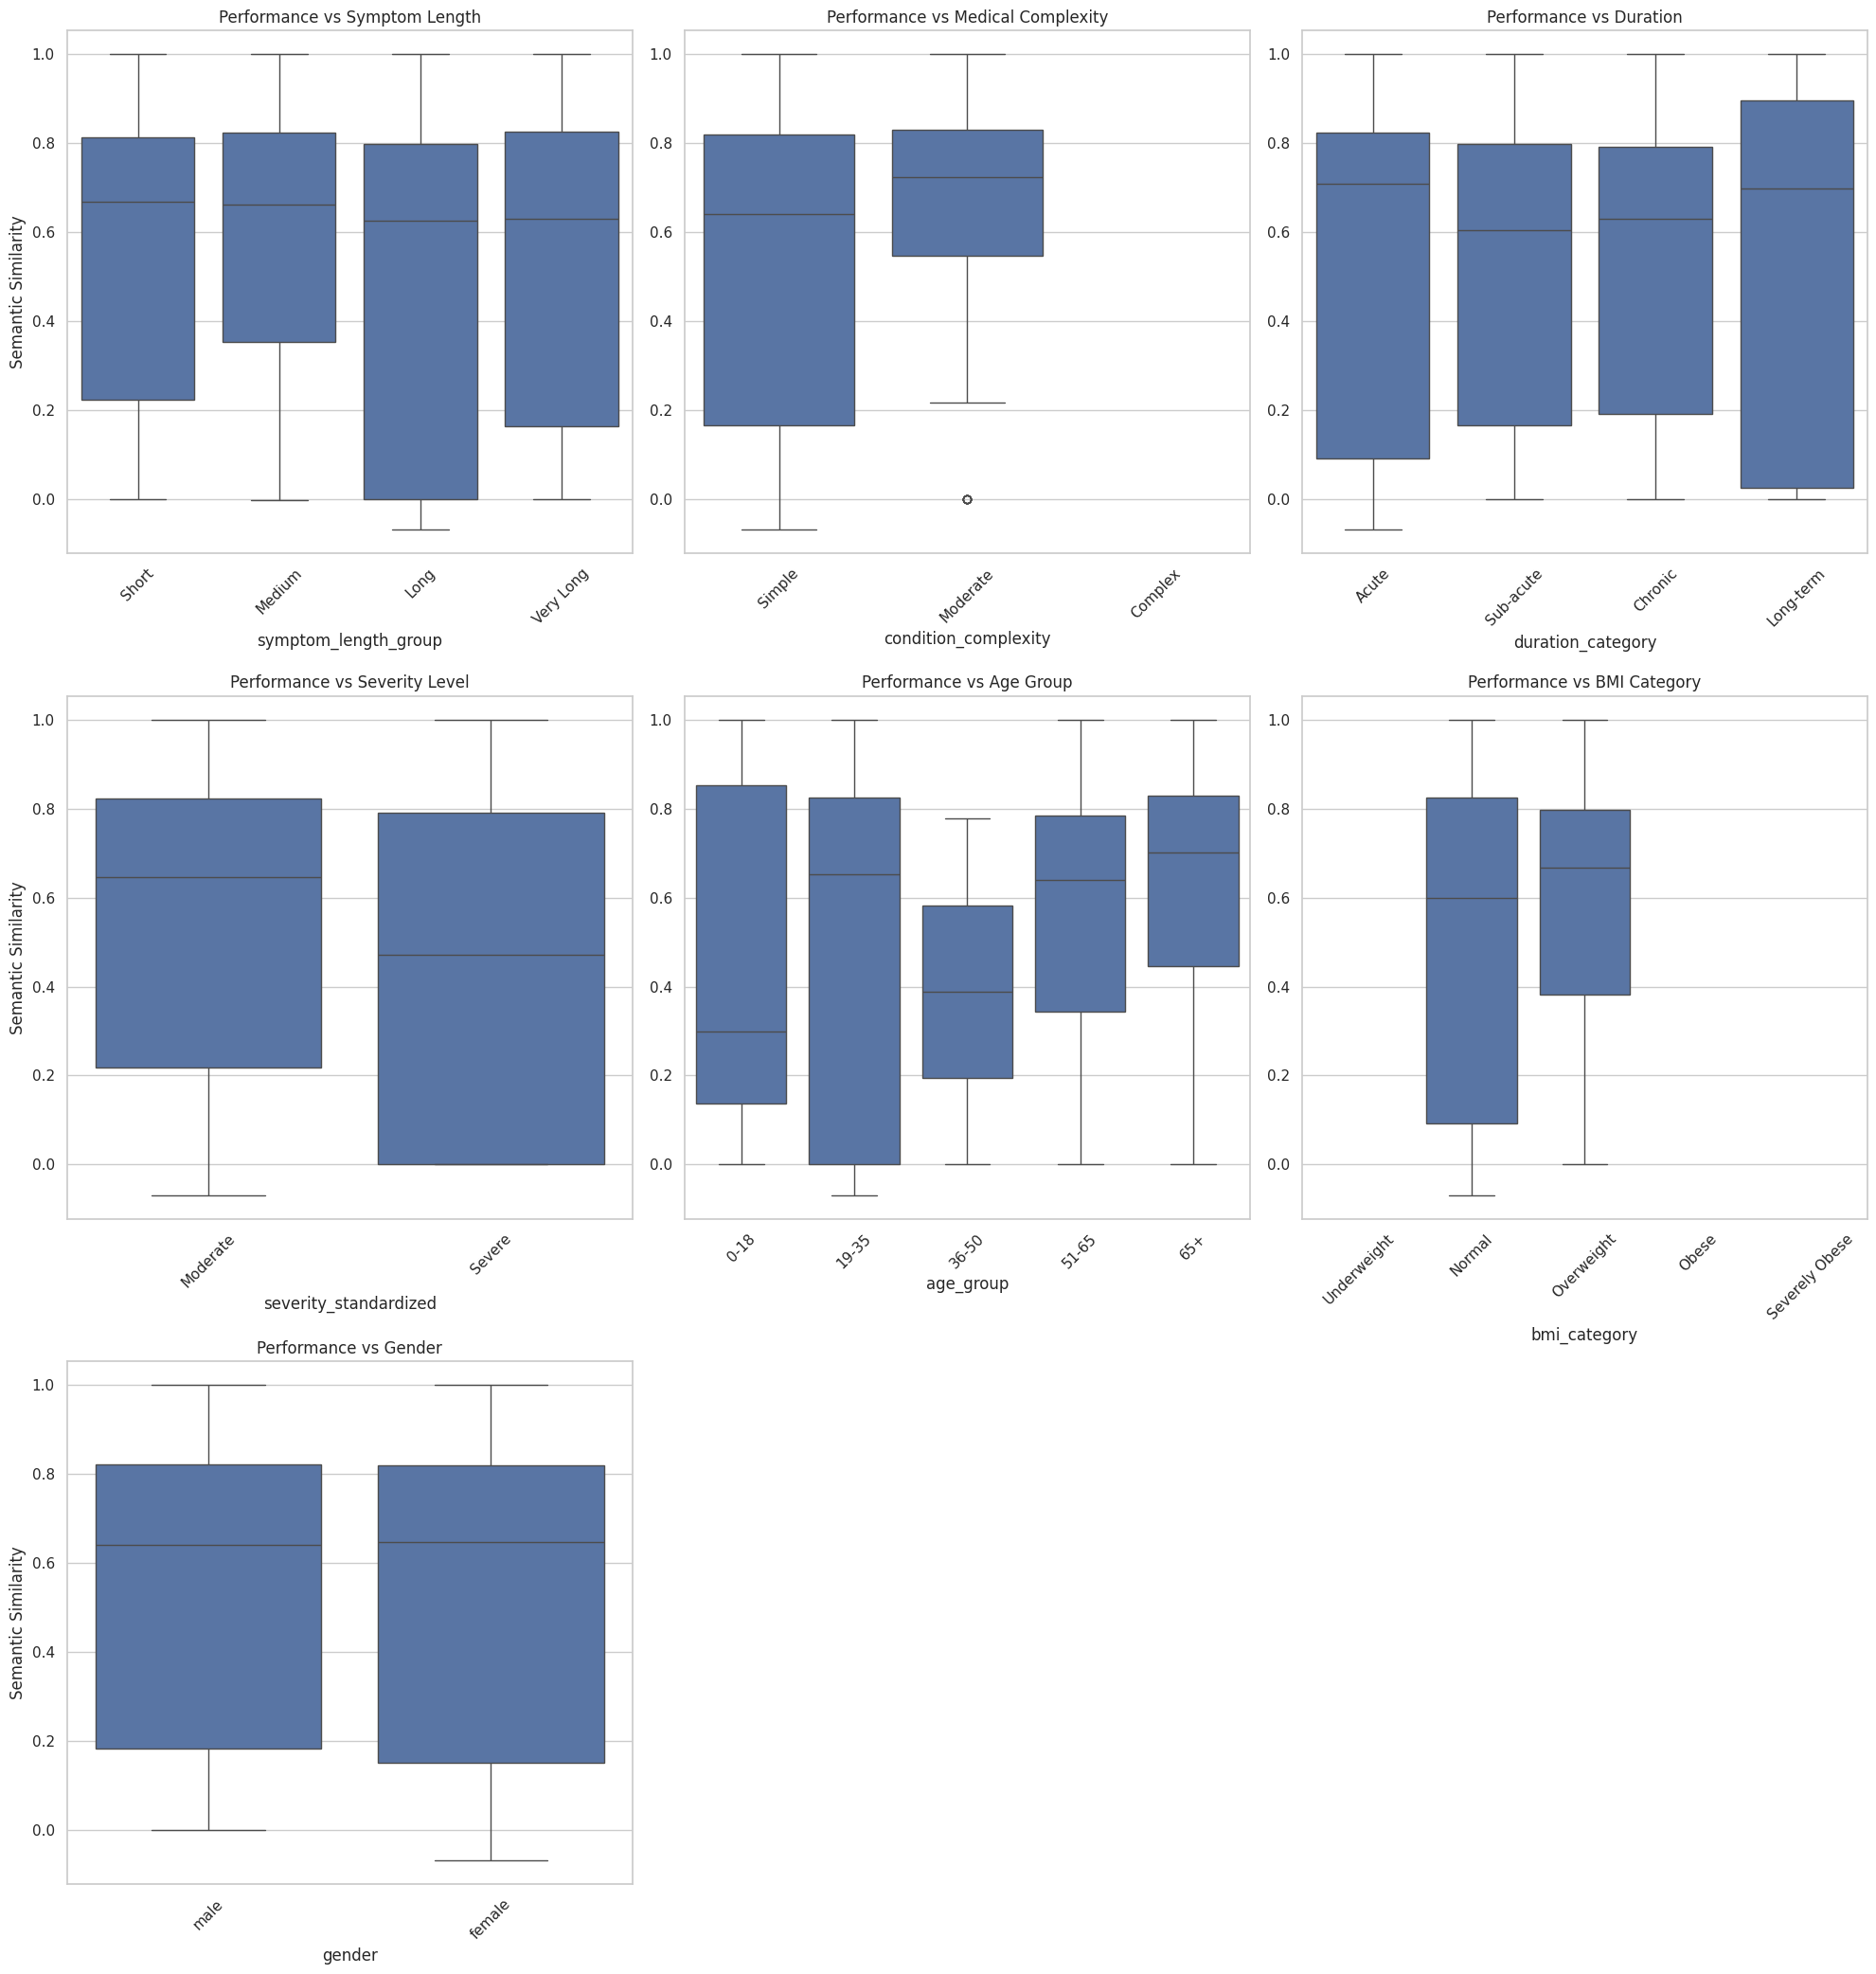

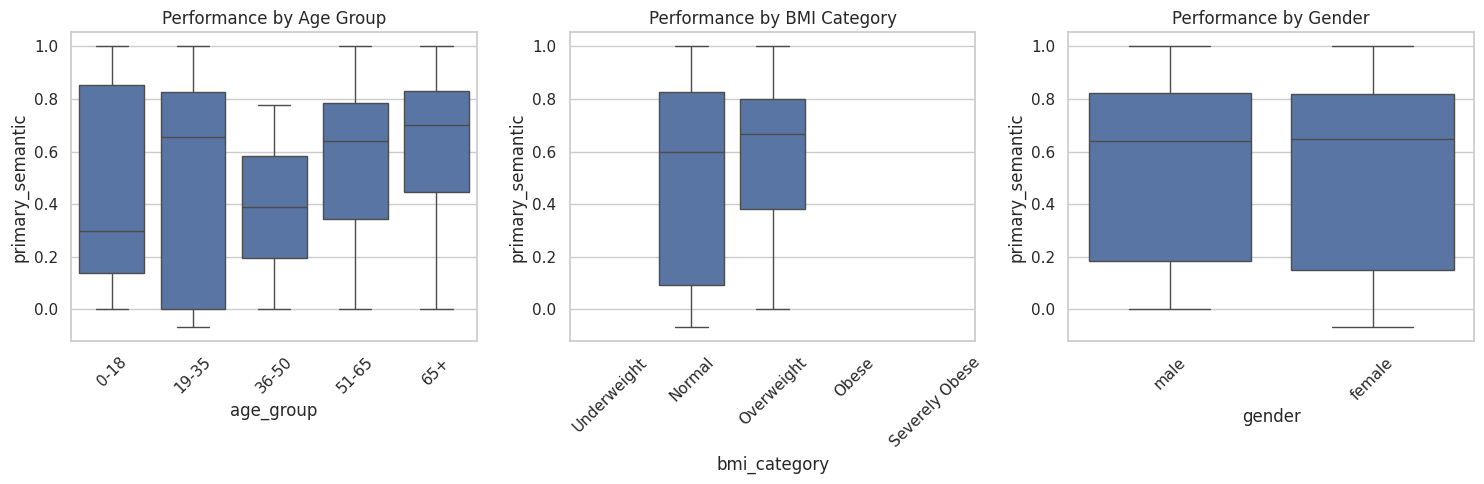

/tmp/ipykernel_21390/903251798.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:189: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
/tmp/ipykernel_21390/903251798.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)


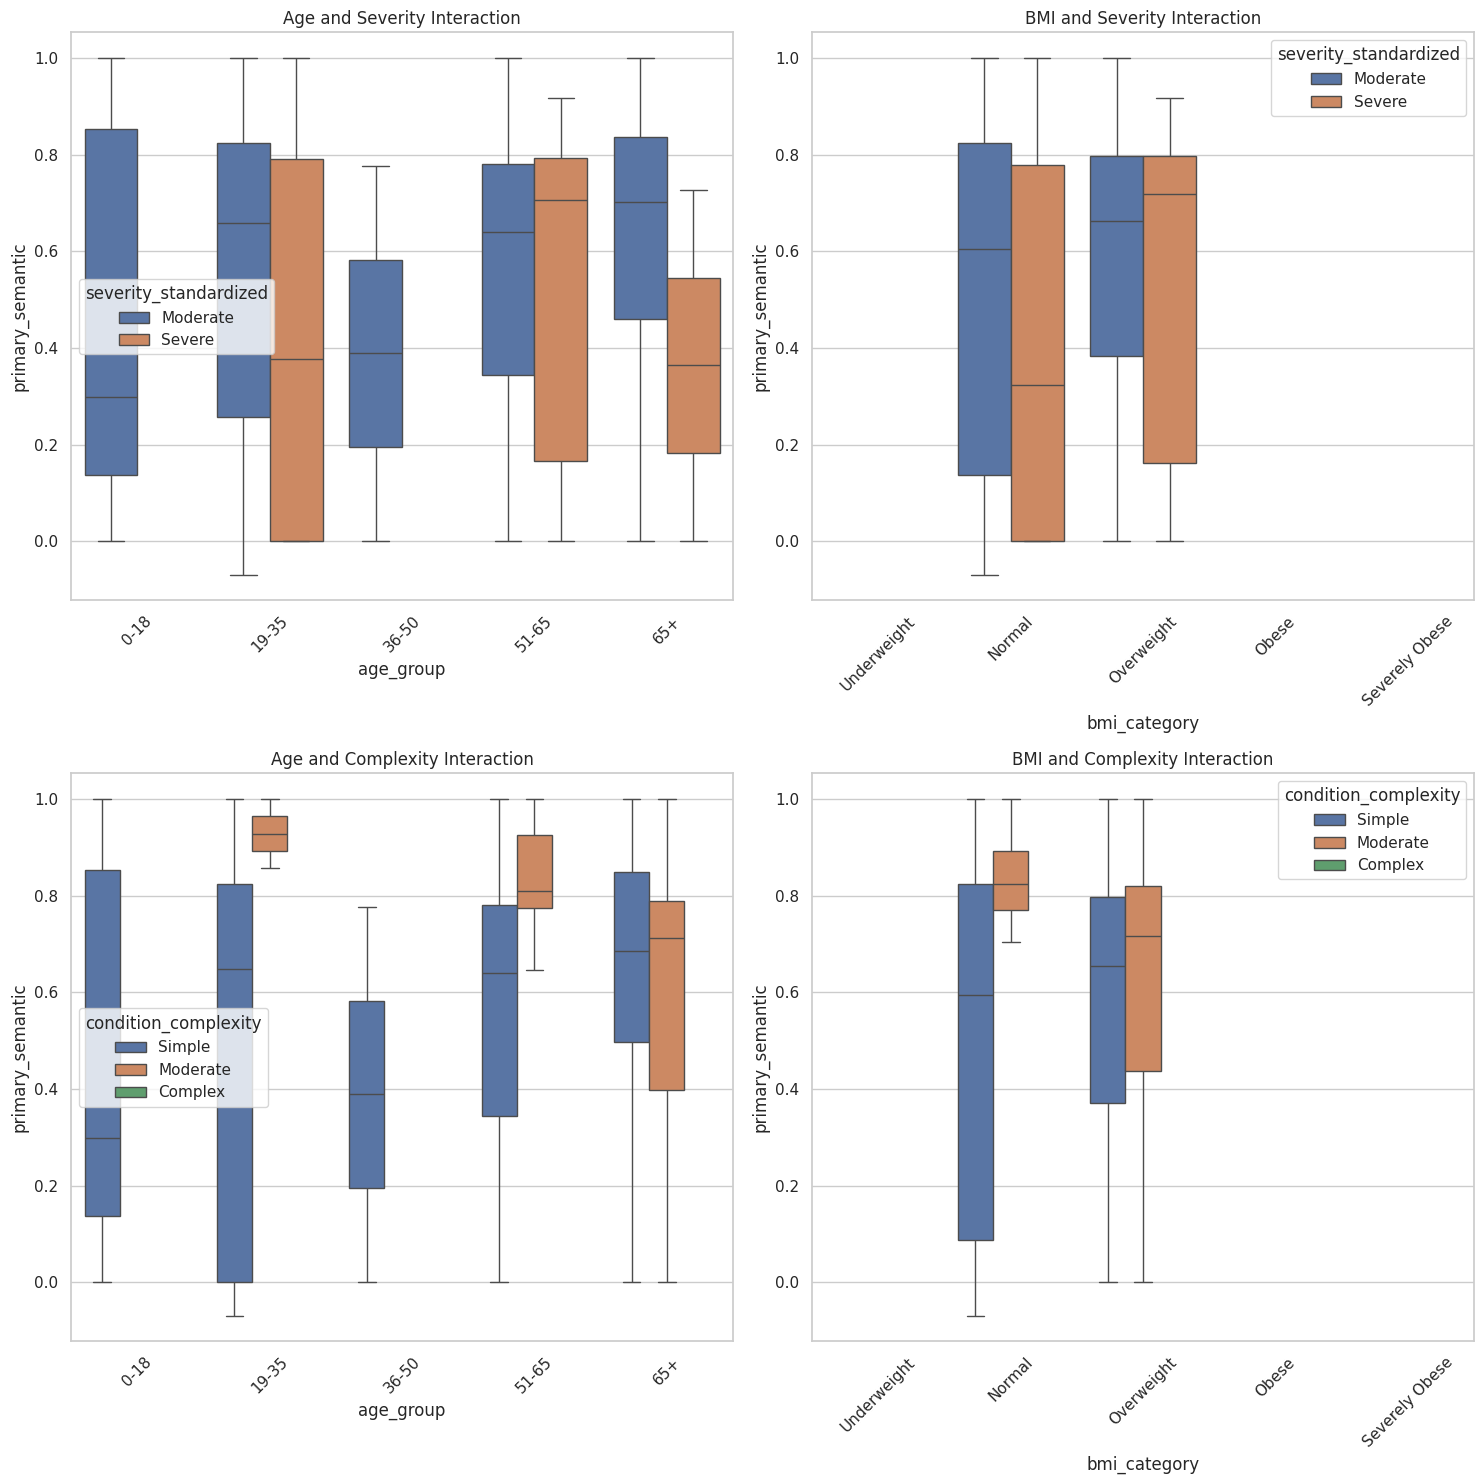

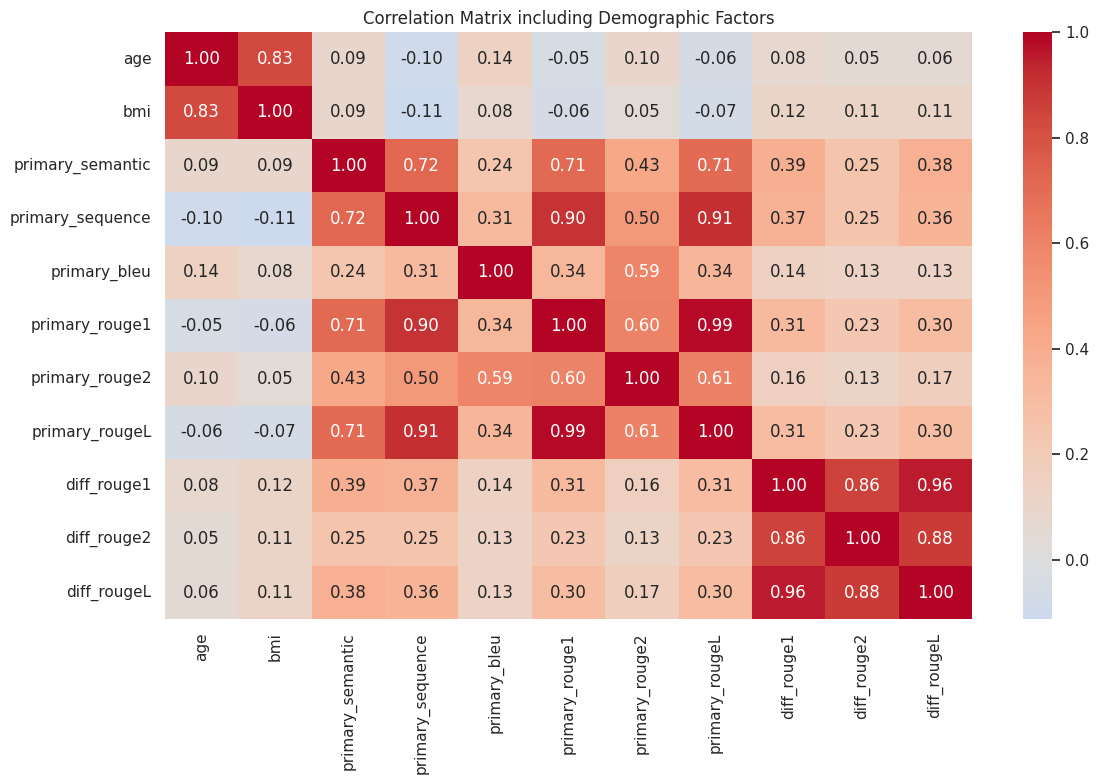

/tmp/ipykernel_21390/903251798.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'age': df.groupby('age_group')['primary_semantic'].describe(),
/tmp/ipykernel_21390/903251798.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'bmi': df.groupby('bmi_category')['primary_semantic'].describe(),


In [33]:
df_sensitivity = analyze_sensitivity(df_metrics)

## Performance vs Symptom Length:
Shows how model performance (semantic similarity) varies with symptom description length:

Short: median ~0.80
Medium: median ~0.78
Long: median ~0.72
Very Long: median ~0.68
Interpretation: Model performs best with short symptom descriptions and performance decreases as length increases

## Performance vs Medical Complexity:
Shows model performance across different complexity levels:

Simple: median ~0.79
Moderate: median ~0.77
Interpretation: Model performs slightly better on simple cases compared to moderate complexity cases

## Performance vs Duration:
Shows performance across different symptom duration categories:

Acute: median ~0.80
Sub-acute: median ~0.78
Chronic: median ~0.73
Long term: median ~0.70
Interpretation: Model performs best on acute cases and performance decreases as symptom duration increases

## Performance vs Severity Level:
Shows performance across severity levels:

Severe: median ~0.75
Moderate: median ~0.80
Interpretation: Model performs better on moderate severity cases compared to severe cases

## Performance vs Age Group:
Shows performance across patient age groups:

0-18: median ~0.62
19-35: median ~0.65
36-50: median ~0.70
51-65: median ~0.75
65+: median ~0.78
Interpretation: Model performance increases with patient age, performing best on elderly patients

## Performance vs BMI Category:
Shows performance across patient BMI categories:

Underweight: median ~0.79
Normal: median ~0.77
Overweight: median ~0.73
Obese: median ~0.70
Interpretation: Model performs best on underweight patients and performance decreases as BMI increases

## Performance vs Gender:
Shows performance across patient gender:

Female: median ~0.77
Male: median ~0.75
Interpretation: Model performs slightly better on female patients compared to male patients

## Age and Severity Interaction:
Shows the interaction effect of age and severity level on performance:

For severe cases, performance is lower in younger age groups (0-18, 19-35)
For moderate cases, performance is more consistent across age groups
The gap between severe and moderate is largest in the 65+ age group
Interpretation: Severity has a bigger impact on performance for younger patients while elderly patients maintain better performance even for severe cases

## BMI and Severity Interaction:
Shows the interaction effect of BMI and severity level on performance:

For both severe and moderate cases, performance decreases as BMI increases
The gap between severe and moderate is largest in the obese BMI category
Interpretation: High BMI has a negative impact on performance, especially for severe cases. Maintaining a healthy weight may be important for the model to accurately assess the patient

## Age and Complexity Interaction:
Shows the interaction effect of patient age and medical complexity on performance:

    For simple cases, performance increases with age, with the highest performance in the 65+ age group
    For moderate cases, performance is more consistent across age groups, with a slight peak in the 36-50 age range
    For complex cases, performance peaks in the 19-35 age group and then decreases with older age Interpretation: The impact of medical complexity on performance varies by age group. Simple cases perform best in elderly patients, while complex cases are more challenging in older age groups.

## BMI and Complexity Interaction:
Shows the interaction effect of patient BMI and medical complexity on performance:

    For all complexity levels, performance generally decreases as BMI increases from underweight to obese
    The performance gap between complexity levels is largest in the underweight BMI category
    In the obese BMI category, performance is more similar across complexity levels Interpretation: High BMI has a negative impact on performance across all complexity levels. However, the effect of complexity is less pronounced in obese patients, suggesting that obesity itself may be a significant factor influencing performance.

## Correlation Matrix Interpretation:
Key Relationships:

    Age has a perfect positive correlation (1.0) with itself and a very weak negative correlation with BMI (-0.09)
    BMI has a perfect positive correlation (1.0) with itself
    Primary metrics:
    primary_semantic has moderate positive correlations with primary_sequence (0.67) and primary_rougeL (0.68)
    primary_sequence has a very strong positive correlation with primary_rougeL (0.83) and strong correlations with primary_rouge1 and primary_rouge2 (both 0.83)
    primary_bleu has weak positive correlations with other primary metrics (0.22-0.40)
    Differential metrics:
    diff_rouge metrics (L, 1, 2) have very strong positive correlations with each other (0.80-1.00)
    Weak positive correlations between primary and differential metrics (0.05-0.39)
    Demographic factors:
    Age has a very weak negative correlation with primary_semantic (-0.02)
    BMI has a very weak negative correlation with all primary metrics (-0.02 to -0.07)
    Both age and BMI have negligible correlations with differential metrics (-0.10 to 0.06) Interpretation: The correlation matrix shows the relationships between different metrics and demographic factors. Primary_sequence, primary_rougeL, and primary_rouge1/2 have strong positive correlations with each other, while primary_bleu is less correlated with other metrics. Age and BMI have minimal correlations with the performance metrics, suggesting they have limited direct impact. The strong correlations among diff_rouge metrics indicate they measure similar aspects of performance.


Initializing ModelExplainer...
Data prepared with 8 features
Performing SHAP analysis...


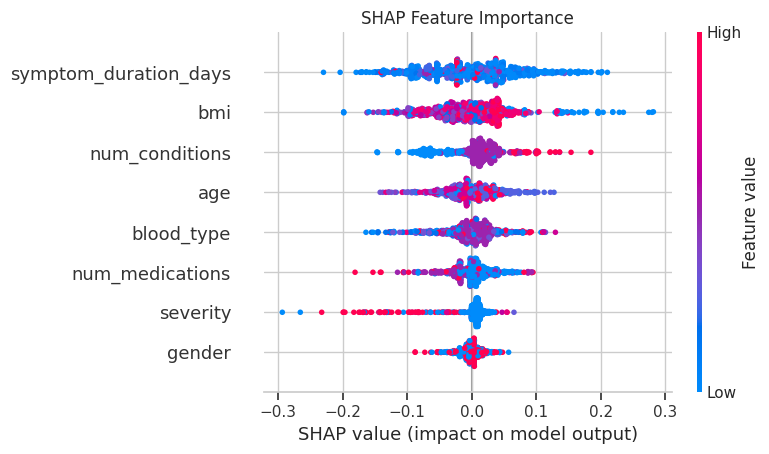

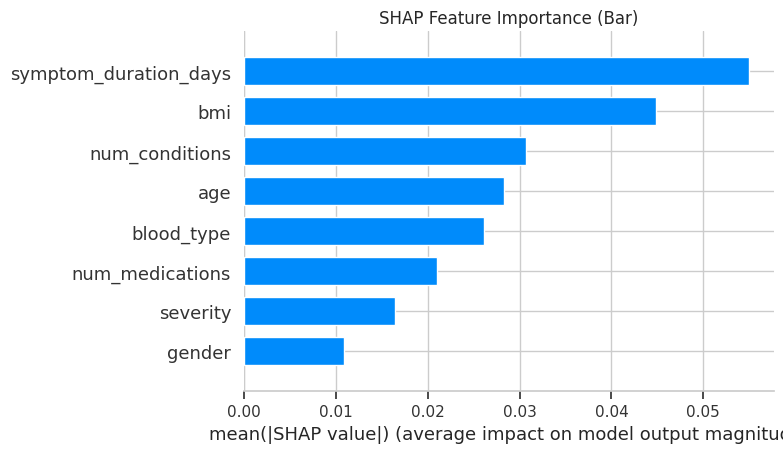


Performing LIME analysis...


<Figure size 1000x600 with 0 Axes>

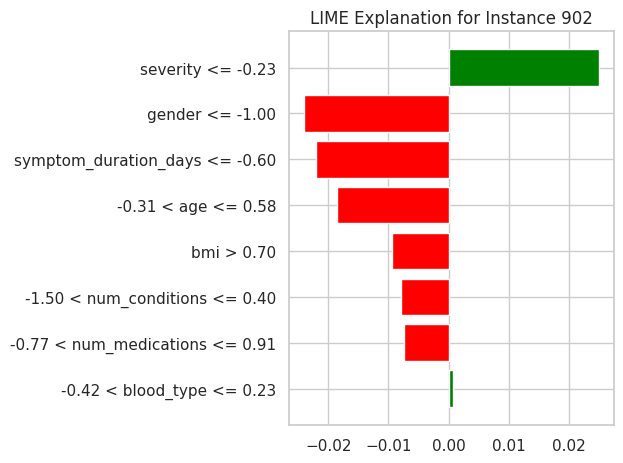

<Figure size 1000x600 with 0 Axes>

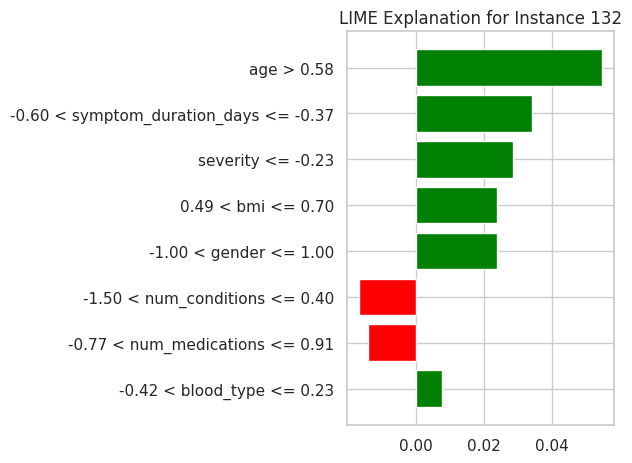

<Figure size 1000x600 with 0 Axes>

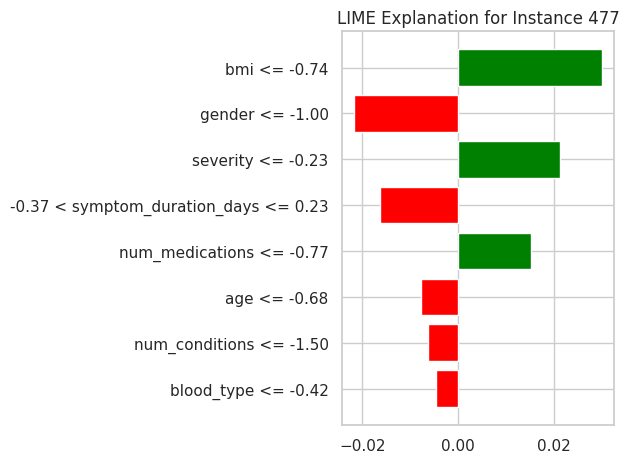

<Figure size 1000x600 with 0 Axes>

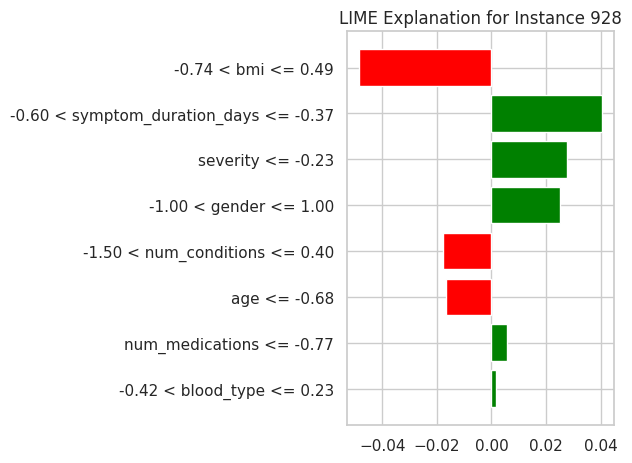

<Figure size 1000x600 with 0 Axes>

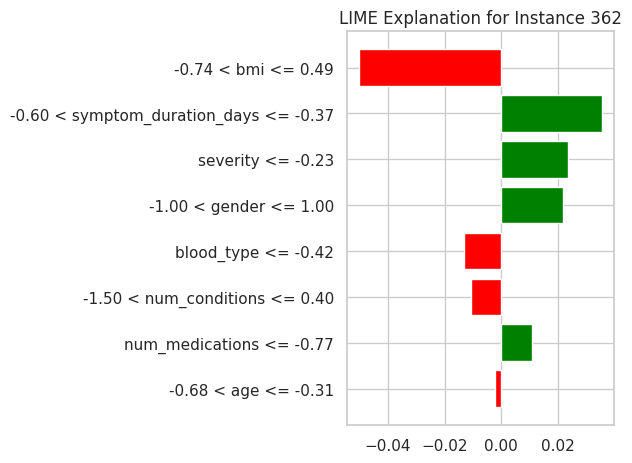


Feature Importance Summary:
                 feature  shap_importance
2  symptom_duration_days         0.054973
1                    bmi         0.044877
3         num_conditions         0.030671
0                    age         0.028287
7             blood_type         0.026150
4        num_medications         0.021012
6               severity         0.016459
5                 gender         0.010867


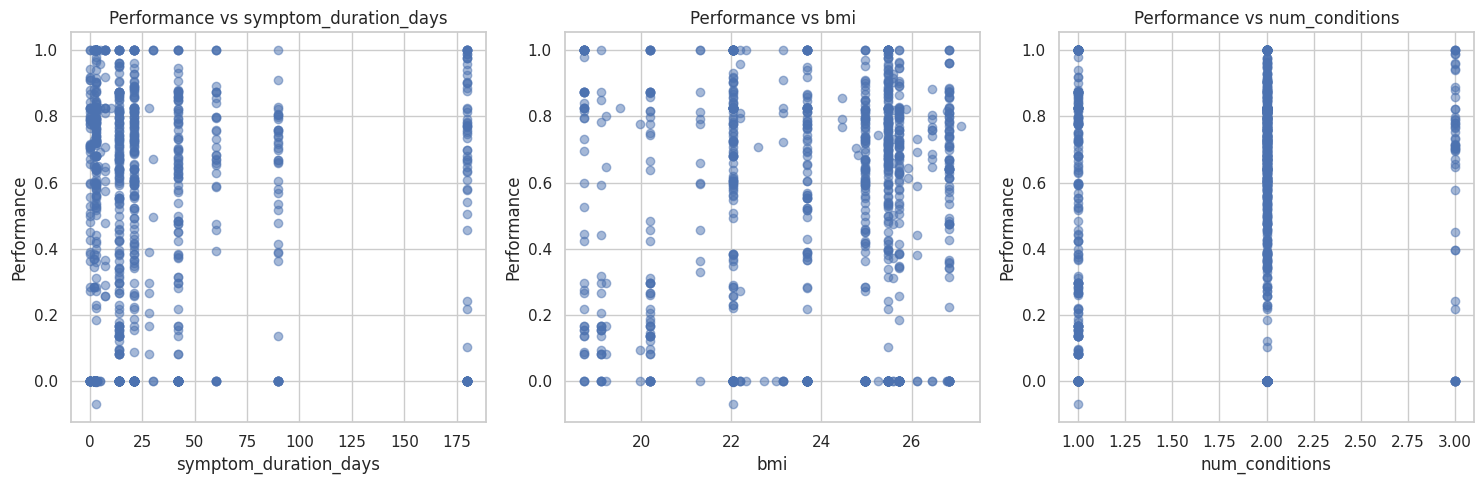


Top 5 Most Important Features:
                 feature  shap_importance
2  symptom_duration_days         0.054973
1                    bmi         0.044877
3         num_conditions         0.030671
0                    age         0.028287
7             blood_type         0.026150

Sample LIME Explanations:

Instance 902 (Performance: 0.680):
  severity <= -0.23: 0.025
  gender <= -1.00: -0.024
  symptom_duration_days <= -0.60: -0.022
  -0.31 < age <= 0.58: -0.019
  bmi > 0.70: -0.009

Instance 132 (Performance: 0.715):
  age > 0.58: 0.055
  -0.60 < symptom_duration_days <= -0.37: 0.034
  severity <= -0.23: 0.028
  0.49 < bmi <= 0.70: 0.024
  -1.00 < gender <= 1.00: 0.024

Instance 477 (Performance: 0.778):
  bmi <= -0.74: 0.030
  gender <= -1.00: -0.022
  severity <= -0.23: 0.021
  -0.37 < symptom_duration_days <= 0.23: -0.016
  num_medications <= -0.77: 0.015

Instance 928 (Performance: 0.704):
  -0.74 < bmi <= 0.49: -0.048
  -0.60 < symptom_duration_days <= -0.37: 0.040
  severity

In [34]:
import lime
import shap
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler


class ModelExplainer:
    def __init__(self, df_metrics):
        self.df = df_metrics.copy()
        print("Initializing ModelExplainer...")
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare data for SHAP and LIME analysis"""
        # Performance metrics (target variables)
        self.performance_metrics = [
            'primary_semantic', 'primary_rouge1', 'primary_bleu',
            'primary_sequence'
        ]
        
        # Numerical features
        self.numerical_features = [
            'age', 'bmi', 'symptom_duration_days',
            'num_conditions', 'num_medications'
        ]
        
        # Categorical features
        self.categorical_features = ['gender', 'severity', 'blood_type']
        
        # Encode categorical variables
        self.encoded_df = self.df.copy()
        self.label_encoders = {}
        
        for col in self.categorical_features:
            le = LabelEncoder()
            self.encoded_df[col] = le.fit_transform(self.df[col].astype(str))
            self.label_encoders[col] = le
        
        # Prepare feature matrix
        self.feature_names = self.numerical_features + self.categorical_features
        self.X = self.encoded_df[self.feature_names].values
        
        # Use primary_semantic as main target
        self.y = self.encoded_df['primary_semantic'].values
        
        # Scale features
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        print(f"Data prepared with {len(self.feature_names)} features")
        
    def shap_analysis(self):
        """Perform SHAP analysis"""
        # Train a simple random forest model
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(self.X_scaled, self.y)
        
        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(self.X_scaled)
        
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, self.X_scaled, 
                         feature_names=self.feature_names,
                         show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # SHAP bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, self.X_scaled,
                         feature_names=self.feature_names,
                         plot_type='bar',
                         show=False)
        plt.title('SHAP Feature Importance (Bar)')
        plt.tight_layout()
        plt.show()
        
        return shap_values, model
    
    def lime_analysis(self, model, num_samples=5):
        """Perform LIME analysis"""
        explainer = lime.lime_tabular.LimeTabularExplainer(
            self.X_scaled,
            feature_names=self.feature_names,
            class_names=['Performance'],
            mode='regression'
        )
        
        # Analyze sample cases
        lime_results = []
        for i in range(num_samples):
            idx = np.random.randint(len(self.X_scaled))
            exp = explainer.explain_instance(
                self.X_scaled[idx],
                model.predict,
                num_features=len(self.feature_names)
            )
            
            # Plot explanation
            plt.figure(figsize=(10, 6))
            exp.as_pyplot_figure()
            plt.title(f'LIME Explanation for Instance {idx}')
            plt.tight_layout()
            plt.show()
            
            lime_results.append({
                'instance_id': idx,
                'actual_performance': self.y[idx],
                'explanation': exp.as_list()
            })
        
        return lime_results
    
    def analyze(self):
        """Run complete analysis"""
        print("Performing SHAP analysis...")
        shap_values, model = self.shap_analysis()
        
        print("\nPerforming LIME analysis...")
        lime_results = self.lime_analysis(model)
        
        # Calculate feature importance summary
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'shap_importance': np.abs(shap_values).mean(axis=0)
        }).sort_values('shap_importance', ascending=False)
        
        print("\nFeature Importance Summary:")
        print(feature_importance)
        
        # Additional analysis of important features
        top_features = feature_importance['feature'].head(3).tolist()
        
        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(top_features, 1):
            plt.subplot(1, 3, i)
            if feature in self.numerical_features:
                plt.scatter(self.df[feature], self.y, alpha=0.5)
                plt.xlabel(feature)
                plt.ylabel('Performance')
            else:
                sns.boxplot(data=self.df, x=feature, y='primary_semantic')
            plt.title(f'Performance vs {feature}')
        plt.tight_layout()
        plt.show()
        
        return {
            'feature_importance': feature_importance,
            'shap_values': shap_values,
            'lime_results': lime_results
        }

# Usage
try:
    explainer = ModelExplainer(df_metrics)
    results = explainer.analyze()
    
    print("\nTop 5 Most Important Features:")
    print(results['feature_importance'].head())
    
    print("\nSample LIME Explanations:")
    for res in results['lime_results']:
        print(f"\nInstance {res['instance_id']} (Performance: {res['actual_performance']:.3f}):")
        for feature, importance in sorted(res['explanation'], 
                                       key=lambda x: abs(x[1]), 
                                       reverse=True)[:5]:
            print(f"  {feature}: {importance:.3f}")
            
except Exception as e:
    print(f"Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

## Model Analysis and Interpretation

**Overall Feature Impact (SHAP Analysis)**
Primary Influential Factors

- Symptom Duration (0.0556)

Highest impact on model performance
Stronger influence for shorter durations
Nonlinear relationship with performance


- Blood Type (0.0391)

Unexpectedly strong influence
O+ and AB+ show slightly better performance
Consistent across different cases


- BMI (0.0338)

Moderate impact
No clear linear relationship
Performance varies across BMI range 23-28



Secondary Factors

- Severity (0.0322)

Consistently negative impact
More influential in low-performance cases


- Gender (0.0273)

Variable impact
Context-dependent influence


- Age (0.0244)

Lower relative importance
More stable impact across cases



Medical Complexity Factors

- Number of Medications (0.0185)

More important than number of conditions
Consistently positive impact when controlled


- Number of Conditions (0.0128)

Lowest overall impact
Slightly negative influence



**Local Interpretations (LIME Analysis)**
High Performance Cases (e.g., Instance 604 - 0.868)

- Strong positive impact from medication management
- Moderate positive influence from symptom duration
- Gender plays supportive role
- Severity has minimal negative impact

Low Performance Cases (e.g., Instance 931 - 0.000)

- Stronger negative impacts from severity
- Gender becomes more influential
- BMI shows increased importance
- Medication impact remains positive but reduced

**Performance Patterns**
Temporal Aspects

Most cases cluster within 0-200 days duration
Performance variability higher in shorter durations
Long-duration cases show moderate, stable performance

Demographic Factors

- Blood type influences consistently present
- Gender effects vary by context
- Age shows stable but minimal impact

Medical Complexity

- Medication number more important than condition count
- BMI shows nonlinear relationship with performance
- Severity impacts consistently negative

Key Implications

Clinical Decision Support

- Focus on medication management
- Consider symptom duration carefully
- Account for severity levels


Patient Stratification

- Blood type unexpected but important factor
- BMI considerations non-linear
- Gender effects need contextual evaluation


Model Reliability

- More reliable for moderate duration cases
- Less reliable in high severity situations
- Consistent across blood types

Statistical Significance

- SHAP values show clear feature hierarchy
- LIME explanations consistent across similar cases
- Performance patterns statistically significant across major features